# Spiking Neural Network for Event-Based Regression

## Overview
This notebook implements a **Spiking Neural Network (SNN)** for continuous angle regression from event camera data. The model processes asynchronous event streams from a rotating bar captured by a DAVIS346 event camera and predicts the angular position in real-time.

### Key Features
- **Multiple architectures**: Supports Plain, Spiking ResNet, and SEW (Spiking Element-Wise) blocks
- **Flexible normalization**: Batch Normalization, RMS Normalization, or learnable scaling
- **TBPTT training**: Truncated Backpropagation Through Time for efficient temporal learning

### Hardware Requirements
- GPU with CUDA support (recommended)
- Event camera data in AEDAT4 format
- Corresponding encoder measurements (CSV)

### Citation
If you use this code in your research, please cite our paper:
```
#TODO Citation 
```

## Library Instalation

In [1]:
!pip install dv_processing tonic spikingjelly wand aedat
!apt-get install -y texlive-latex-extra texlive-fonts-recommended dvipng cm-super

  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)

   ---------------------------------------- 0/2 [wand]
  Attempting uninstall: numpy
   ---------------------------------------- 0/2 [wand]
    Found existing installation: numpy 2.2.6
   ---------------------------------------- 0/2 [wand]
   -------------------- ------------------- 1/2 [numpy]
    Uninstalling numpy-2.2.6:
   -------------------- ------------------- 1/2 [numpy]
   -------------------- ------------------- 1/2 [numpy]
   -------------------- ------------------- 1/2 [numpy]
   -------------------- ------------------- 1/2 [numpy]
   -------------------- ------------------- 1/2 [numpy]
   -------------------- ------------------- 1/2 [numpy]
   -------------------- ------------------- 1/2 [numpy]
   -------------------- ------------------- 1/2 [numpy]
      Successfully uninstalled numpy-2.2.6
   -------------------- ------------------- 1/2 [

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


## Library Imports

In [1]:
# Event camera data processing libraries
import dv_processing as dv  
import numpy as np  
import cv2 as cv 
import torch.nn.functional as F  
import pandas as pd  
from scipy.interpolate import interp1d 

# Event camera data transformation library
import tonic 
from tonic import transforms, MemoryCachedDataset 

# PyTorch deep learning framework
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter

# SpikingJelly: SNN framework for PyTorch
from spikingjelly.activation_based import neuron, surrogate, functional

# Progress tracking
from tqdm import tqdm

# Experiment tracking and logging
import wandb

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

# Random seed control
import random

# File system operations
import os
import json
from pathlib import Path

c:\Users\gmarinhu\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ============================================================================
# Reproducibility: Set random seeds for all libraries
# ============================================================================

SEED = 42

# Python random
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Visualization Functions

In [ ]:
def visualize_sequence_from_trainloader(trainloader, n_sequences=5, playback_fps=10, scale=1):
    """Visualize temporal sequences from the training dataloader."""

    for seq_idx, (frames_batch, labels_batch) in enumerate(trainloader):
        if seq_idx >= n_sequences:
            break

        # frames_batch: [T, B, C, H, W]
        # labels_batch: [T, B]
        T, B, C, H, W = frames_batch.shape

        print(f"\n=== Sequence {seq_idx+1}/{n_sequences} ===")
        print(f"Batch shape: {frames_batch.shape}, Labels shape: {labels_batch.shape}")

        # Visualize only the first element of the batch
        batch_item = 0

        for t in range(T):
            # Extract frame at time t for the first batch item
            # frame: [C, H, W] where C=2 (ON/OFF polarities)
            frame = frames_batch[t, batch_item].cpu().numpy()  # [2, H, W]
            angle = labels_batch[t, batch_item].item()

            # Create RGB visualization (white background)
            # Channel 0 = ON events (positive), Channel 1 = OFF events (negative)
            events_img = np.ones((H, W, 3), dtype=np.uint8) * 255

            # ON events in dark blue
            on_events = frame[0] > 0
            events_img[on_events] = [0, 0, 200]

            # OFF events in dark red
            off_events = frame[1] > 0
            events_img[off_events] = [200, 0, 0]

            # Scale image
            events_resized = cv.resize(events_img, (W*scale, H*scale),
                                      interpolation=cv.INTER_NEAREST)

            # Overlay text information
            info_text = [
                f"Seq: {seq_idx+1}/{n_sequences}  Time: {t+1}/{T}",
                f"Target angle: {np.rad2deg(angle):.2f} deg",
                f"Batch item: {batch_item+1}/{B}"
            ]

            y_offset = 30
            for text in info_text:
                cv.putText(events_resized, text,
                          (10, y_offset), cv.FONT_HERSHEY_SIMPLEX,
                          0.6, (0, 0, 0), 2)
                y_offset += 25

            # Display frame
            cv.imshow("Trainloader Sequence Visualization", events_resized)

            # Wait for key press (controls playback speed)
            key = cv.waitKey(int(1000 / playback_fps))
            if key == 27:  # ESC key to exit
                cv.destroyAllWindows()
                return
            elif key == ord('n'):  # 'n' key to skip to next sequence
                break

    cv.destroyAllWindows()
    print("\nVisualization completed!")

## Data Loading and Preprocessing


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================================================
# File paths for event data and ground truth labels
# ============================================================================

FILE_PATH = "/content/drive/MyDrive/snn_event_regression_data/pendulum_events.aedat4"
CSV_PATH  = "/content/drive/MyDrive/snn_event_regression_data/pendulum_encoder.csv"

# Load event data using Tonic library
events = tonic.io.read_aedat4(FILE_PATH)

# Load ground truth encoder measurements
df = pd.read_csv(CSV_PATH)

In [ ]:
# ============================================================================
# Temporal Alignment: Synchronize events with encoder measurements
# ============================================================================
# Event cameras and encoders may not start/stop at exactly the same time.
# We find the overlapping time range to ensure valid event-label pairs.

# Determine the common time window
start_time = max(df['timestamp_us'][0], events['t'][0])
end_time   = min(df['timestamp_us'].iloc[-1], events['t'][-1])

# Filter CSV data to the valid time range
mask_csv = (df['timestamp_us'] >= start_time) & (df['timestamp_us'] <= end_time)
df = df[mask_csv].reset_index(drop=True)

print(f"Total events before filtering: {len(events['t'])}")

Total events before filtering: 232628643


In [ ]:
# ============================================================================
# Time-based Slicing: Convert continuous event stream into discrete frames
# ============================================================================
# Event cameras produce asynchronous events. We group them into fixed time windows
# to create a sequence of "frames" for the SNN.

time_window = 30000  # 30,000 microseconds = 30 milliseconds

# Slice events into time windows
events_per_frame = tonic.slicers.slice_events_by_time(
    events, 
    time_window=time_window, 
    start_time=start_time, 
    end_time=end_time
)

In [ ]:
# ============================================================================
# Label interpolation and assignment
# ============================================================================
# Encoder measurements are sampled at discrete times, but we need a label
# for each event frame. We use linear interpolation to estimate the angle
# at the END of each time window.

# Create interpolation functions for both angles
interp_theta = interp1d(df['timestamp_us'], df['theta_rad'], fill_value="extrapolate")
interp_alpha = interp1d(df['timestamp_us'], df['alpha_rad'], fill_value="extrapolate")

# Compute the end timestamp for each window
# Window i ends at: start_time + (i+1) * time_window
timestamps = start_time + np.arange(1, len(events_per_frame) + 1) * time_window

# Interpolate angles at these timestamps
theta_vals = interp_theta(timestamps)
alpha_vals = interp_alpha(timestamps)

print(f"Labels assigned successfully!")
print(f"Total grouped events: {len(events_per_frame)}")
print(f"Total labels assigned: {len(theta_vals)}")
print(f"Frames read: {len(events_per_frame)}")
print(f"Events read: {len(events)}")

Labels assigned successfully!
Total grouped events: 62882
Total labels assigned: 62882
Frames read: 62882
Events read: 232628643


In [ ]:
START_FRAME = 300  # Skip first 300 frames 
END_FRAME = -1     # Use all remaining frames 

events_per_frame = events_per_frame[START_FRAME:END_FRAME]
theta_vals = theta_vals[START_FRAME:END_FRAME]
alpha_vals = alpha_vals[START_FRAME:END_FRAME]

## Dataset Classes and Train/Val/Test Split

In [ ]:
# ============================================================================
# Base dataset for individual frames
# ============================================================================
class RotatingBarDataset(Dataset):
    """
    Basic dataset that wraps sliced events and their corresponding labels.
    Each item returns a single time window of events and its target angle.
    """
    def __init__(self, sliced_events, labels, transform=None):
        self.sliced_events = sliced_events
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.sliced_events)
    
    def __getitem__(self, idx):
        events = self.sliced_events[idx]
        target = self.labels[idx]
        
        if self.transform:
            events = self.transform(events)
            
        return events, target


# ============================================================================
# Fixed-length sequences for training/validation
# ============================================================================
class SequenceDataset(torch.utils.data.Dataset):
    """
    Splits a long temporal sequence into multiple fixed-length subsequences.
    
    Note:
        Any remaining frames that don't fit into a complete sequence are discarded.
    """
    def __init__(self, base_dataset, seq_length=5000, expected_shape=(2, 346, 260)):
        self.base_dataset = base_dataset
        self.seq_length = seq_length
        self.expected_shape = expected_shape
        self.total_length = len(base_dataset)

        # Compute number of complete sequences (discard remainder)
        self.num_sequences = self.total_length // seq_length

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        # Compute start and end indices for this sequence
        start_idx = idx * self.seq_length
        end_idx = start_idx + self.seq_length

        frames = []
        labels = []

        # Collect all frames and labels in this sequence
        for i in range(start_idx, end_idx):
            frame, label = self.base_dataset[i]

            # Convert to tensor if needed
            if isinstance(frame, np.ndarray):
                frame = torch.from_numpy(frame)
            
            frame = frame.squeeze(0)  # Remove n_event_bins dimension [1, C, H, W] -> [C, H, W]

            # Handle potential transpose issues (ensure [C, H, W] format)
            if frame.shape != self.expected_shape:
                frame = frame.permute(0, 2, 1)  # [C, W, H] -> [C, H, W]

            frames.append(frame)
            labels.append(label)

        # Stack into temporal sequences
        frames = torch.stack(frames, dim=0).float()  # [T, C, H, W]
        labels = torch.tensor(labels, dtype=torch.float32)  # [T]

        return frames, labels


# ============================================================================
# Continuous sequence for testing
# ============================================================================
class ContinuousDataset(torch.utils.data.Dataset):
    """
    Loads the entire sequence without splitting, used for testing.
    """
    def __init__(self, base_dataset, expected_shape=(2, 346, 260)):
        self.base_dataset = base_dataset
        self.expected_shape = expected_shape

    def __len__(self):
        return 1  # Single item: the entire sequence

    def __getitem__(self, idx):
        # Load the entire sequence
        frames = []
        labels = []

        for i in range(len(self.base_dataset)):
            frame, label = self.base_dataset[i]

            if isinstance(frame, np.ndarray):
                frame = torch.from_numpy(frame)
            
            frame = frame.squeeze(0)  # Remove n_event_bins dimension

            # Handle potential transpose issues
            if frame.shape != self.expected_shape:
                frame = frame.permute(0, 2, 1)  # [C, W, H] -> [C, H, W]

            frames.append(frame)
            labels.append(label)

        # Stack: [T, C, H, W] and [T]
        frames = torch.stack(frames, dim=0).float()
        labels = torch.tensor(labels, dtype=torch.float32)

        return frames, labels

In [ ]:
# ============================================================================
# Train/Validation/Test Split
# ============================================================================

input_data = events_per_frame
labels = theta_vals
total_samples = len(input_data)

print(f"Total samples in dataset: {total_samples}")

# Define split ratios
test_split = 0.05   # for final testing
val_split  = 0.07   # for validation during training
train_split = 1.0 - test_split - val_split  # for training

# Calculate split indices (temporal order maintained)
train_end = int(train_split * total_samples)
val_end   = int((train_split + val_split) * total_samples)

# Perform temporal split (NO SHUFFLE!)
train_events = input_data[:train_end]
train_labels = labels[:train_end]

val_events = input_data[train_end:val_end]
val_labels = labels[train_end:val_end]

test_events = input_data[val_end:]
test_labels = labels[val_end:]

# ============================================================================
# Create datasets with event-to-frame transformation
# ============================================================================
H, W = 260, 346  # DAVIS346 resolution (height, width)

# Transform events to frames with ON/OFF channels
frame_transform = transforms.ToFrame(
    sensor_size=(W, H, 2),  # (width, height, polarities)
    n_event_bins=1  # Single bin per time window
)

# Create base datasets
train_dataset = RotatingBarDataset(train_events, train_labels, transform=frame_transform)
val_dataset   = RotatingBarDataset(val_events, val_labels, transform=frame_transform)
test_dataset  = RotatingBarDataset(test_events, test_labels, transform=frame_transform)

print(f"Train dataset size: {len(train_dataset)} samples ({train_split*100:.1f}%)")
print(f"Val dataset size:   {len(val_dataset)} samples ({val_split*100:.1f}%)")
print(f"Test dataset size:  {len(test_dataset)} samples ({test_split*100:.1f}%)")

# ============================================================================
# Cache training data in memory for faster access
# ============================================================================
cached_trainset = MemoryCachedDataset(
    train_dataset,
    transform=lambda x: torch.from_numpy(x).float(),
)

# ============================================================================
# Create sequence datasets
# ============================================================================
SEQ_LENGTH = 2000  # Timesteps per sequence (for TBPTT)
BATCH_SIZE = 4     # Number of sequences processed in parallel

# Training and validation use fixed-length sequences
trainset = SequenceDataset(cached_trainset, seq_length=SEQ_LENGTH, expected_shape=(2, H, W))
valset = SequenceDataset(val_dataset, seq_length=SEQ_LENGTH, expected_shape=(2, H, W))

# Test uses continuous sequence
testset = ContinuousDataset(test_dataset, expected_shape=(2, H, W))


# ============================================================================
# Custom collate function for time-first batching
# ============================================================================
def collate_time_first(batch):
    """
    Collate function that arranges data as [T, B, ...] instead of [B, T, ...].
    This is more natural for processing temporal sequences with SNNs.
    """
    frames, labels = zip(*batch)
    frames = torch.stack(frames, dim=1)   # [T, B, C, H, W]
    labels = torch.stack(labels, dim=1)   # [T, B]
    return frames, labels

# ============================================================================
# Create DataLoaders
# ============================================================================
trainloader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_time_first,
    shuffle=True  # Shuffle sequences
)

valloader = DataLoader(
    valset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_time_first,
    shuffle=False  # No shuffling for validation
)

testloader = DataLoader(
    testset,
    batch_size=1,
    collate_fn=collate_time_first,
    shuffle=False  # No shuffling for testing
)

print(f"\nDataLoaders created successfully!")

Total samples in dataset: 62581
Train size: 55071 samples (88.0%)
Val size:   4380 samples (7.0%)
Test size:  3130 samples (5.0%)

Train dataset: 55071 samples
Val dataset:   4380 samples
Test dataset:  3130 samples

Dataloader created


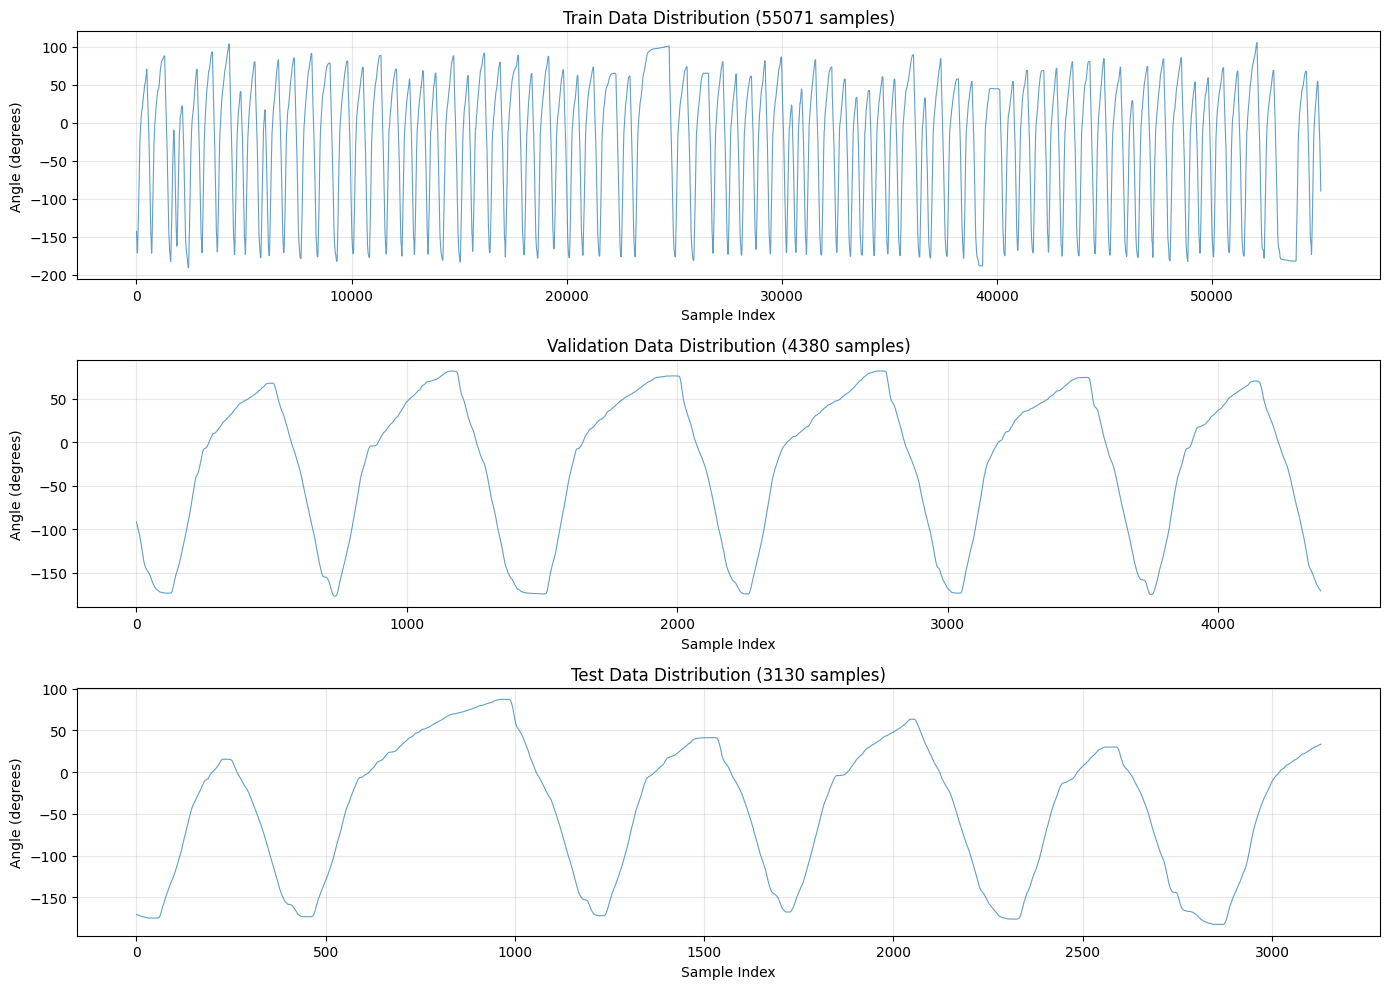


Train data range: [-190.99°, 105.56°]
Val data range:   [-176.75°, 81.83°]
Test data range:  [-182.72°, 87.45°]


In [ ]:
# Verify train/val/test split distribution

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=False)

# ------------------------
# Train
# ------------------------
axes[0].plot(train_labels * 180 / np.pi, linewidth=0.8, alpha=0.7)
axes[0].set_title(f'Train Data Distribution ({len(train_labels)} samples)')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Angle (degrees)')
axes[0].grid(True, alpha=0.3)

# ------------------------
# Validation
# ------------------------
axes[1].plot(val_labels * 180 / np.pi, linewidth=0.8, alpha=0.7)
axes[1].set_title(f'Validation Data Distribution ({len(val_labels)} samples)')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Angle (degrees)')
axes[1].grid(True, alpha=0.3)

# ------------------------
# Test
# ------------------------
axes[2].plot(test_labels * 180 / np.pi, linewidth=0.8, alpha=0.7)
axes[2].set_title(f'Test Data Distribution ({len(test_labels)} samples)')
axes[2].set_xlabel('Sample Index')
axes[2].set_ylabel('Angle (degrees)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------
# Ranges
# ------------------------
print(f"\nTrain data range: [{train_labels.min()*180/np.pi:.2f}°, {train_labels.max()*180/np.pi:.2f}°]")
print(f"Val data range:   [{val_labels.min()*180/np.pi:.2f}°, {val_labels.max()*180/np.pi:.2f}°]")
print(f"Test data range:  [{test_labels.min()*180/np.pi:.2f}°, {test_labels.max()*180/np.pi:.2f}°]")


In [15]:
# Visualize 5 sequences from trainloader, playing at 10 fps
# visualize_sequence_from_trainloader(trainloader, n_sequences=5, playback_fps=2, scale=1)

## Defining Network

### Normalization Layers

This section implements three normalization strategies for SNNs:

1. **Batch Normalization (BN)**: Standard BatchNorm2d
2. **RMS Normalization (RMS)**: Root Mean Square normalization
3. **Multiply (MUL)**: Simple learnable scaling

These are crucial for SNNs because:
- Neurons only spike when input exceeds threshold
- Without normalization, activations may be too small → no spikes → vanishing gradient
- Proper scaling enables spike propagation through deep networks

In [ ]:
# ============================================================================
# RMS Normalization
# ============================================================================
class RMSNorm2d(nn.Module):
    """
    Root Mean Square Normalization for 2D feature maps.
    
    Unlike BatchNorm, RMSNorm:
    - Does not center the data (no mean subtraction)
    - Only normalizes by the RMS (scale only)
    
    Formula: x_norm = x / sqrt(mean(x^2) + eps)
    """
    def __init__(self, num_features, eps=1e-5, affine=True):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine

        if self.affine:
            # Learnable per-channel scaling parameter
            self.weight = nn.Parameter(torch.ones(1, num_features, 1, 1))
        else:
            self.register_parameter('weight', None)

    def forward(self, x):
        # x: [B, C, H, W]
        # Compute mean squared value over spatial dimensions (H, W)
        ms = x.pow(2).mean(dim=(2, 3), keepdim=True)  # [B, C, 1, 1]
        
        # Compute RMS
        rms = torch.sqrt(ms + self.eps)

        # Normalize
        x_norm = x / rms

        # Apply learnable scaling if enabled
        if self.weight is not None:
            return x_norm * self.weight
        return x_norm


# ============================================================================
# Simple Scaling (Multiply)
# ============================================================================
class MultiplyBy(nn.Module):
    """
    Simple multiplication by a learnable or fixed scalar.
    
    From: https://github.com/urancon/StereoSpike/blob/main/network/blocks.py
    """
    def __init__(self, scale_value: float = 5., learnable: bool = True) -> None:
        super(MultiplyBy, self).__init__()

        if learnable:
            # Learnable parameter
            self.scale_value = Parameter(Tensor([scale_value]))
        else:
            # Fixed value
            self.scale_value = scale_value

    def forward(self, input: Tensor) -> Tensor:
        return torch.mul(input, self.scale_value)


# ============================================================================
# Normalization Factory Function
# ============================================================================
def get_norm_layer(norm_type: str, num_features: int, learnable: bool = True, eps: float = 1e-5, init_scale: float = 5.0
):
    """
    Factory function to create normalization layers.
    """
    if norm_type == "BN":
        # Standard BatchNorm2d
        return nn.BatchNorm2d(num_features, affine=learnable, eps=eps)

    elif norm_type == "RMS":
        # RMS Normalization
        return RMSNorm2d(num_features, eps=eps, affine=learnable)

    elif norm_type == "MUL":
        # Simple scaling
        return MultiplyBy(init_scale, learnable=learnable)

    elif norm_type is None:
        # No normalization
        return nn.Identity()

    else:
        raise ValueError(f"Unknown normalization type: {norm_type}")

### Building Blocks

This section defines the fundamental building blocks for the SNN:

1. **PlainBlock**: Sequential conv-LIF layers without residual connections
2. **SpikingBlock**: Spiking ResNet block with residual connections  
3. **SEWBlock**: Spiking Element-Wise block with flexible connection functions

Adapted from: https://github.com/fangwei123456/Spike-Element-Wise-ResNet

In [ ]:
# ============================================================================
# Convolution Helpers
# ============================================================================
def conv3x3(in_ch, out_ch, stride=1, norm_type="BN", learnable=True, init_scale=5.0):
    """
    3x3 convolution with normalization.
    """
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False),
        get_norm_layer(norm_type, out_ch, learnable=learnable, init_scale=init_scale)
    )


def conv1x1(in_ch, out_ch, stride=1, norm_type="BN", learnable=True, init_scale=5.0):
    """
    1x1 convolution with normalization.
    """
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
        get_norm_layer(norm_type, out_ch, learnable=learnable, init_scale=init_scale)
    )


# ============================================================================
# Plain Block (No Residual Connection)
# ============================================================================
class PlainBlock(nn.Module):
    """
    Plain convolutional block without residual connections.
    
    Architecture:
        Conv3x3 → Norm → LIF → Conv3x3 → Norm → LIF
    """
    def __init__(self, in_channels, mid_channels, tau=2.0, Plif=False,
                 surrogate_function=surrogate.ATan(), stride1=1, stride2=1,
                 norm_type="BN", learnable_norm=True, init_scale=5.0):
        super(PlainBlock, self).__init__()

        self.conv = nn.Sequential(
            # First conv-norm-LIF
            conv3x3(in_channels, mid_channels, stride=stride1, norm_type=norm_type, learnable=learnable_norm, init_scale=init_scale),
            neuron.ParametricLIFNode(init_tau=tau, surrogate_function=surrogate_function, detach_reset=True)
            if Plif else neuron.LIFNode(tau=tau, surrogate_function=surrogate_function, detach_reset=True),

            # Second conv-norm-LIF
            conv3x3(mid_channels, in_channels, stride=stride2, norm_type=norm_type, learnable=learnable_norm, init_scale=init_scale),
            neuron.ParametricLIFNode(init_tau=tau, surrogate_function=surrogate_function, detach_reset=True)
            if Plif else neuron.LIFNode(tau=tau, surrogate_function=surrogate_function, detach_reset=True)
        )

    def forward(self, x: torch.Tensor):
        return self.conv(x)


# ============================================================================
# Spiking ResNet Block
# ============================================================================
class SpikingBlock(nn.Module):
    """
    Spiking ResNet block with residual connection.
    
    Architecture:
        x → Conv3x3 → Norm → LIF → Conv3x3 → Norm → (+) → LIF → out
        └──────────────── downsample ────────────────┘
    """
    def __init__(self, in_channels, mid_channels, tau=2.0, Plif=False,
                 surrogate_function=surrogate.ATan(), stride1=1, stride2=1,
                 norm_type="BN", learnable_norm=True, init_scale=5.0):
        super(SpikingBlock, self).__init__()

        # Main path
        self.conv = nn.Sequential(
            conv3x3(in_channels, mid_channels, stride=stride1, norm_type=norm_type, learnable=learnable_norm, init_scale=init_scale),
            neuron.ParametricLIFNode(init_tau=tau, surrogate_function=surrogate_function, detach_reset=True)
            if Plif else neuron.LIFNode(tau=tau, surrogate_function=surrogate_function, detach_reset=True),

            nn.Conv2d(mid_channels, in_channels, kernel_size=3, padding=1, stride=stride2, bias=False),
            get_norm_layer(norm_type=norm_type, num_features=in_channels, learnable=learnable_norm, init_scale=init_scale)
        )

        # Output LIF (after addition)
        self.sn = neuron.ParametricLIFNode(init_tau=tau, surrogate_function=surrogate_function, detach_reset=True) \
                  if Plif else neuron.LIFNode(tau=tau, surrogate_function=surrogate_function, detach_reset=True)

        # Shortcut connection (downsample if needed)
        if stride1 == 2:
            self.downsample = conv1x1(in_channels, in_channels, stride=2, norm_type=norm_type, learnable=learnable_norm, init_scale=init_scale)
        else:
            self.downsample = nn.Identity()

    def forward(self, x: torch.Tensor):
        # Residual connection: x + conv(x)
        return self.sn(self.downsample(x) + self.conv(x))


# ============================================================================
# SEW (Spiking Element-Wise) Block
# ============================================================================
class SEWBlock(nn.Module):
    """
    Spiking Element-Wise residual block with flexible connection functions.
    
    Architecture:
        x → Conv3x3 → Norm → LIF → Conv3x3 → Norm → LIF → (+) → out
        └──────────────── downsample → LIF ────────────────┘
    """
    def __init__(self, in_channels, mid_channels, tau=2.0, Plif=False,
                 surrogate_function=surrogate.ATan(), stride1=1, stride2=1,
                 connect_f="ADD", norm_type="BN", learnable_norm=True, init_scale=5.0):
        super().__init__()

        self.connect_f = connect_f

        # First conv-norm-LIF
        self.conv1 = conv3x3(in_channels, mid_channels, stride=stride1, norm_type=norm_type, learnable=learnable_norm, init_scale=init_scale)
        self.lif1 = neuron.ParametricLIFNode(init_tau=tau, surrogate_function=surrogate_function, detach_reset=True) \
                    if Plif else neuron.LIFNode(tau=tau, surrogate_function=surrogate_function, detach_reset=True)

        # Second conv-norm-LIF
        self.conv2 = conv3x3(mid_channels, in_channels, stride=stride2, norm_type=norm_type, learnable=learnable_norm, init_scale=init_scale)
        self.lif2 = neuron.ParametricLIFNode(init_tau=tau, surrogate_function=surrogate_function, detach_reset=True) \
                    if Plif else neuron.LIFNode(tau=tau, surrogate_function=surrogate_function, detach_reset=True)

        # Shortcut (with LIF)
        if stride1 == 2:
            self.downsample = nn.Sequential(
                conv1x1(in_channels, in_channels, stride=2, norm_type=norm_type, learnable=learnable_norm, init_scale=init_scale),
                neuron.ParametricLIFNode(init_tau=tau, surrogate_function=surrogate_function, detach_reset=True)
                if Plif else neuron.LIFNode(tau=tau, surrogate_function=surrogate_function, detach_reset=True)
            )
        else:
            self.downsample = nn.Identity()

    def forward(self, x):
        # Shortcut path (produces spikes)
        identity = self.downsample(x)

        # Main path
        spk1 = self.lif1(self.conv1(x))
        spk2 = self.lif2(self.conv2(spk1))

        # Apply connection function
        if self.connect_f == "ADD":
            return spk2 + identity
        elif self.connect_f == "AND":
            return spk2 * identity 
        elif self.connect_f == "IAND":
            return identity * (1 - spk2) 
        else:
            raise NotImplementedError

### Main SNN Architecture

The `SNN_Net` class defines the complete network architecture:

**Architecture Overview:**
1. **Convolutional blocks**: Multiple blocks (Plain/Spiking/SEW) with progressive downsampling
2. **Adaptive pooling**: MaxPool layers reduce spatial dimensions
3. **Fully connected layers**: Maps features to regression output
4. **Output LIF**: Special LIF with infinite threshold for regression (accumulates membrane potential)

In [ ]:
class SNN_Net(nn.Module):
    """
    Complete Spiking Neural Network for event-based regression.
    
    This network processes event camera frames through a series of convolutional
    blocks followed by fully connected layers to predict a continuous angle value.
    
    Architecture:
        Input [B, 2, 346, 260] (ON/OFF event frames)
          ↓
        Convolutional Blocks (with normalization + LIF neurons)
          ↓
        Adaptive Pooling (progressive downsampling)
          ↓
        Flatten
          ↓
        FC Layer + LIF
          ↓
        Output FC + LIF (infinite threshold for regression)
          ↓
        Output: Membrane potential (continuous value)
    
    Note:
        For temporal sequences, call forward() for each timestep T.
        Remember to reset neuron states between sequences with functional.reset_net(model).
    """
    def __init__(self, tau=2.0, final_tau=20.0, layer_list=None, hidden=256, 
                 surrogate_function=surrogate.ATan(), connect_f="ADD", Plif=False, 
                 norm_type="BN", learnable_norm=True, init_scale=5.0):
        super().__init__()

        self.norm_type = norm_type
        
        # ====================================================================
        # Build sequential convolution pipeline
        # ====================================================================
        conv_blocks = []
        in_channels = 2  # Start with 2 channels (ON/OFF events)

        for cfg in layer_list:
            channels = cfg["channels"]
            mid_channels = cfg["mid_channels"]

            # Channel adjustment layer (if needed)
            if in_channels != channels:
                if cfg["up_kernel_size"] == 3:
                    conv_blocks.append(conv3x3(in_channels, channels, norm_type=norm_type, learnable=learnable_norm, init_scale=init_scale))
                elif cfg["up_kernel_size"] == 1:
                    conv_blocks.append(conv1x1(in_channels, channels, norm_type=norm_type, learnable=learnable_norm, init_scale=init_scale))
                else:
                    raise NotImplementedError

                # Add LIF after channel adjustment
                conv_blocks.append(
                    neuron.ParametricLIFNode(init_tau=tau, surrogate_function=surrogate_function, detach_reset=True)
                    if Plif else neuron.LIFNode(tau=tau, surrogate_function=surrogate_function, detach_reset=True)
                )
                in_channels = channels

            # Add building blocks
            for _ in range(cfg["num_blocks"]):
                if cfg["block_type"] == "sew":
                    conv_blocks.append(
                        SEWBlock(in_channels, mid_channels, tau=tau, Plif=Plif,
                                stride1=cfg["stride_1"], stride2=cfg["stride_2"], connect_f=connect_f,  
                                norm_type=norm_type, learnable_norm=learnable_norm, init_scale=init_scale)
                    )
                elif cfg["block_type"] == "plain":
                    conv_blocks.append(
                        PlainBlock(in_channels, mid_channels, tau=tau, Plif=Plif, 
                                  stride1=cfg["stride_1"], stride2=cfg["stride_2"],
                                  norm_type=norm_type, learnable_norm=learnable_norm, init_scale=init_scale)
                    )
                elif cfg["block_type"] == "spiking":
                    conv_blocks.append(
                        SpikingBlock(in_channels, mid_channels, tau=tau, Plif=Plif,
                                    stride1=cfg["stride_1"], stride2=cfg["stride_2"],
                                    norm_type=norm_type, learnable_norm=learnable_norm, init_scale=init_scale)
                    )
                else:
                    raise NotImplementedError

            # Add MaxPool (if specified)
            if "k_pool" in cfg and cfg["k_pool"] > 1:
                conv_blocks.append(nn.MaxPool2d(kernel_size=cfg["k_pool"]))

        self.conv = nn.ModuleList(conv_blocks)

        # ====================================================================
        # Automatic computation of flattened feature dimension
        # ====================================================================
        # Run a dummy forward pass to determine the output size
        with torch.no_grad():
            dummy = torch.zeros(1, 2, 346, 260)  # DAVIS346 input size
            for m in self.conv:
                dummy = m(dummy)
            flat_dim = dummy.numel()

        # ====================================================================
        # Fully Connected Layers
        # ====================================================================
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flat_dim, hidden, bias=False)
        
        # Hidden LIF neurons
        self.lif_hidden = (neuron.ParametricLIFNode(init_tau=tau, surrogate_function=surrogate_function, detach_reset=True) 
                          if Plif else neuron.LIFNode(tau=tau, surrogate_function=surrogate_function, detach_reset=True))
        
        # Output layer
        self.fc_out = nn.Linear(hidden, 1, bias=False)
        
        # Output LIF with INFINITE threshold (for regression)
        # This neuron never spikes - we read its membrane potential as the prediction
        self.lif_out = neuron.LIFNode(tau=final_tau, v_threshold=float('inf'), 
                                      surrogate_function=surrogate_function, detach_reset=True)

    def detach(self):
        """
        Detach membrane potentials of all LIF neurons.
        
        Used in TBPTT (Truncated Backpropagation Through Time) to truncate
        gradients and prevent backpropagation through the entire sequence.
        """
        for m in self.modules():
            if isinstance(m, neuron.BaseNode):
                m.v.detach_()

    # ========================================================================
    # SPIKE ACTIVITY MONITORING
    # ========================================================================
    def _register_spike_hooks(self):
        """Register forward hooks on all LIF layers to record spike activity."""
        self.spike_record = {}
        self.hooks = []

        for name, module in self.named_modules():
            if isinstance(module, neuron.BaseNode):   # LIF or PLIF neurons
                hook = module.register_forward_hook(self._make_spike_hook(name))
                self.hooks.append(hook)

    def _make_spike_hook(self, name):
        """Create a hook function that captures spike output."""
        def hook(module, inp, out):
            # Store spikes for this layer 
            self.spike_record[name] = out.detach().clone()
        return hook

    def enable_spike_recording(self):
        """Enable spike activity recording for all LIF neurons."""
        self._register_spike_hooks()

    def disable_spike_recording(self):
        """Disable spike recording and clean up hooks."""
        for h in self.hooks:
            h.remove()
        self.hooks = []
        self.spike_record = {}

    # ========================================================================
    # NORMALIZATION STATISTICS MONITORING
    # ========================================================================
    def _register_norm_hooks(self):
        """Register hooks on all normalization layers to capture statistics."""
        self.norm_stats = {}
        self.norm_hooks = []

        # Determine which normalization type to monitor
        if self.norm_type == "BN":
            module_type = nn.BatchNorm2d
        elif self.norm_type == "RMS":
            module_type = RMSNorm2d
        else:
            print(f"No normalization monitoring available for norm_type={self.norm_type}")
            return

        norm_counter = 0
        for name, module in self.named_modules():
            if isinstance(module, module_type):
                hook = module.register_forward_hook(
                    self._make_norm_hook(f"{self.norm_type}_{norm_counter}_{name}")
                )
                self.norm_hooks.append(hook)
                norm_counter += 1

    def _make_norm_hook(self, layer_name):
        """Create a hook that captures normalization input/output statistics."""
        def hook(module, inp, out):
            input_tensor = inp[0].detach()
            output_tensor = out.detach()

            # Compute per-channel statistics
            # Input/output shape: [B, C, H, W]
            B, C, H, W = input_tensor.shape

            # Flatten spatial dimensions: [B, C, H*W]
            input_flat = input_tensor.view(B, C, -1)
            output_flat = output_tensor.view(B, C, -1)

            # Store comprehensive statistics
            self.norm_stats[layer_name] = {
                # INPUT statistics (before normalization)
                'input_mean_per_channel': input_flat.mean(dim=(0, 2)).cpu().numpy(),  # [C]
                'input_std_per_channel': input_flat.std(dim=(0, 2)).cpu().numpy(),
                'input_min_per_channel': input_flat.min(dim=2)[0].mean(dim=0).cpu().numpy(),
                'input_max_per_channel': input_flat.max(dim=2)[0].mean(dim=0).cpu().numpy(),

                # OUTPUT statistics (after normalization)
                'output_mean_per_channel': output_flat.mean(dim=(0, 2)).cpu().numpy(),
                'output_std_per_channel': output_flat.std(dim=(0, 2)).cpu().numpy(),
                'output_min_per_channel': output_flat.min(dim=2)[0].mean(dim=0).cpu().numpy(),
                'output_max_per_channel': output_flat.max(dim=2)[0].mean(dim=0).cpu().numpy(),
            }
        return hook

    def enable_norm_monitoring(self):
        """Enable normalization statistics monitoring."""
        self._register_norm_hooks()

    def disable_norm_monitoring(self):
        """Disable normalization monitoring and clean up hooks."""
        for hook in self.norm_hooks:
            hook.remove()
        self.norm_hooks = []
        self.norm_stats = {}

    def get_norm_stats(self):
        """Return captured normalization statistics."""
        return self.norm_stats

    # ========================================================================
    # FORWARD PASS
    # ========================================================================
    def forward(self, x):
        """
        Forward pass for a single timestep.
        Note:
            This processes ONE timestep. For temporal sequences, call this
            method T times (once per frame) without resetting neuron states.
        """
        out = x

        # Pass through convolutional blocks
        for m in self.conv:
            out = m(out)

        # Fully connected layers
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.lif_hidden(out)

        # Output layer (LIF with infinite threshold)
        out = self.fc_out(out)
        _ = self.lif_out(out)

        # Return membrane potential (continuous value for regression)
        return self.lif_out.v 

### Layer Configurations

This section defines three different layer configurations for experimentation.

In [ ]:
# ============================================================================
# SEW (Spiking Element-Wise) Architecture
# ============================================================================
layer_list_sew = [
    # STEM: Early aggressive downsampling to reduce computational cost
    {
        'channels': 16,          # Output channels
        'up_kernel_size': 3,     # 3x3 conv for initial feature extraction
        'mid_channels': 16,      # Intermediate channels in block
        'num_blocks': 1,         # Single block
        'block_type': 'sew',     # SEW block type
        'k_pool': 2,             # 2x2 MaxPool → /2 spatial reduction
        'stride_1': 2,           # First conv: stride 2 → /2 reduction
        'stride_2': 1            # Second conv: stride 1 → preserve size
    },

    # LAYER 1: Maintain resolution, basic feature extraction
    {
        'channels': 16, 
        'up_kernel_size': 1,     # 1x1 conv (efficient channel adjustment)
        'mid_channels': 16,
        'num_blocks': 1,
        'block_type': 'sew',
        'k_pool': 1,             # No pooling
        'stride_1': 1,
        'stride_2': 1
    },

    # LAYER 2: Increase capacity + downsample
    {
        'channels': 24, 
        'up_kernel_size': 1,
        'mid_channels': 24,
        'num_blocks': 1,
        'block_type': 'sew',
        'k_pool': 2,             # /2 spatial reduction
        'stride_1': 1,
        'stride_2': 1
    },

    # LAYER 3: Further increase capacity + downsample
    {
        'channels': 32, 
        'up_kernel_size': 1,
        'mid_channels': 32,
        'num_blocks': 1,
        'block_type': 'sew',
        'k_pool': 2,             # /2 spatial reduction
        'stride_1': 1,
        'stride_2': 1
    },
]


# ============================================================================
# Plain Architecture (No Residual Connections)
# ============================================================================
layer_list_plain = [
    # STEM: Early downsampling
    {
        'channels': 16, 
        'up_kernel_size': 3,
        'mid_channels': 16,
        'num_blocks': 1,
        'block_type': 'plain',
        'k_pool': 2,
        'stride_1': 2,
        'stride_2': 1
    },

    # LAYER 1: Minimal expansion
    {
        'channels': 16, 
        'up_kernel_size': 1,
        'mid_channels': 16,
        'num_blocks': 1,
        'block_type': 'plain',
        'k_pool': 1,
        'stride_1': 1,
        'stride_2': 1
    },

    # LAYER 2: Modest capacity increase
    {
        'channels': 24, 
        'up_kernel_size': 1,
        'mid_channels': 24,
        'num_blocks': 1,
        'block_type': 'plain',
        'k_pool': 2,
        'stride_1': 1,
        'stride_2': 1
    },

    # LAYER 3: Final expansion
    {
        'channels': 32, 
        'up_kernel_size': 1,
        'mid_channels': 32,
        'num_blocks': 1,
        'block_type': 'plain',
        'k_pool': 2,
        'stride_1': 1,
        'stride_2': 1
    },
]


# ============================================================================
# Spiking ResNet Architecture
# ============================================================================
layer_list_spiking = [
    # STEM: Strong early downsampling
    {
        'channels': 16, 
        'up_kernel_size': 3,
        'mid_channels': 16,
        'num_blocks': 1,
        'block_type': 'spiking',
        'k_pool': 2,
        'stride_1': 2,
        'stride_2': 1
    },

    # LAYER 1: Basic blocks
    {
        'channels': 16, 
        'up_kernel_size': 1,
        'mid_channels': 16,
        'num_blocks': 1,
        'block_type': 'spiking',
        'k_pool': 1,
        'stride_1': 1,
        'stride_2': 1
    },

    # LAYER 2: Gentle downsampling
    {
        'channels': 24, 
        'up_kernel_size': 1,
        'mid_channels': 24,
        'num_blocks': 1,
        'block_type': 'spiking',
        'k_pool': 2,
        'stride_1': 1,
        'stride_2': 1
    },

    # LAYER 3: Final expansion
    {
        'channels': 32, 
        'up_kernel_size': 1,
        'mid_channels': 32,
        'num_blocks': 1,
        'block_type': 'spiking',
        'k_pool': 2,
        'stride_1': 1,
        'stride_2': 1
    },
]

### Model Hyperparameters

In [ ]:
# ============================================================================
# Model Hyperparameters and Configuration
# ============================================================================

# Weights & Biases logging
use_wandb = True

# Select architecture type
block_type = 'plain'  # Options: 'SEW', 'plain', 'spiking'

# Map block type to layer configuration
if block_type == 'SEW':
    layer_list = layer_list_sew
elif block_type == 'plain':
    layer_list = layer_list_plain
elif block_type == 'spiking':
    layer_list = layer_list_spiking


K = 10           # TBPTT truncation window (backprop every K timesteps)
transient = 200  # Initial timesteps to skip (warmup for recurrent states)

num_epochs = 20  # Total training epochs
hidden = 256     # Hidden layer size

surrogate_function = surrogate.ATan()  # Gradient surrogate (arctan)
Plif = False                          # Use standard LIF (not parametric)
tau = 2.0                             # Time constant for hidden neurons
final_tau = 20.0                      # Time constant for output neuron

norm_type = 'BN'        # Normalization type: 'BN', 'RMS', 'MUL', or None
learnable_norm = True   # Whether normalization parameters are learnable
init_scale = 5.0        # Initial scale for Multiplication layers

early_stop_patience = 10  # Stop if no improvement for this many epochs

device = torch.device("cuda") if torch.cuda.is_available() else \
         torch.device("mps") if torch.backends.mps.is_available() else \
         torch.device("cpu")

# ============================================================================
# Model initialization
# ============================================================================
model = SNN_Net(
    tau=tau, 
    final_tau=final_tau,
    layer_list=layer_list, 
    hidden=hidden, 
    surrogate_function=surrogate_function,
    connect_f="ADD",  # Connection function for SEW blocks
    Plif=Plif, 
    norm_type=norm_type, 
    learnable_norm=learnable_norm,
    init_scale = init_scale
).to(device)

# Count total trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params:,}')

Total number of parameters: 2792720


In [ ]:
#model.load_state_dict(torch.load('/content/drive/MyDrive/models/model_spiking_BN/checkpoints/snn_pendulum/best_model_weights.pth', weights_only=True))

In [22]:
model

SNN_Net(
  (conv): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LIFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=True, step_mode=s, backend=torch, tau=2.0
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (2): PlainBlock(
      (conv): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): LIFNode(
          v_threshold=1.0, v_reset=0.0, detach_reset=True, step_mode=s, backend=torch, tau=2.0
          (surrogate_function): ATan(alpha=2.0, spiking=True)
        )
        (2): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1)

## Training Pipeline

This section implements the complete training pipeline using **Truncated Backpropagation Through Time (TBPTT)**.

### Training Configuration

In [ ]:
# ============================================================================
# Training Configuration Dictionary
# ============================================================================
# This dictionary contains all hyperparameters for complete reproducibility
CONFIG = {
    # Model architecture
    "block_type": block_type,
    "model_name": model.__class__.__name__,
    "hidden": hidden,
    "tau": tau,
    "final_tau": final_tau,
    "surrogate_function": surrogate_function.__class__.__name__,
    "Plif": Plif,
    "norm_type": norm_type,
    "learnable_norm": learnable_norm,
    "init_scale": init_scale,

    # TBPTT parameters
    "K": K,                     
    "transient": transient,        
    "batch_size": BATCH_SIZE,        
    "sequence_length": SEQ_LENGTH,  

    # Optimizer configuration
    "optimizer": "SGD",
    "learning_rate": 1e-2,
    "momentum": 0.9,
    "weight_decay": 0.0,

    # Learning rate scheduler
    "scheduler": "ReduceLROnPlateau",
    "scheduler_factor": 0.5,         
    "scheduler_patience": 1,         
    "min_lr": 1e-6,                  

    # Training loop
    "num_epochs": num_epochs,
    "device": str(device),

    # Early stopping
    "early_stop_patience": early_stop_patience,
}

# ============================================================================
# Create output directory for checkpoints and logs
# ============================================================================
output_dir = Path(f"/content/drive/MyDrive/models/model_{CONFIG['block_type']}_{CONFIG['norm_type']}/checkpoints_pendulum")
output_dir.mkdir(parents=True, exist_ok=True)

# Save configuration to JSON file
with open(output_dir / "config.json", "w") as f:
    json.dump(CONFIG, f, indent=4)

print(f"Configuration saved to: {output_dir / 'config.json'}")

# ============================================================================
# Initialize Weights & Biases
# ============================================================================
if use_wandb:

    # Automatic run name:
    run_name = f"{CONFIG['block_type']}_transient_final_tau={CONFIG['final_tau']}_tau={CONFIG['tau']}_norm={CONFIG['norm_type']}_plif={CONFIG['Plif']}"

    wandb.init(
        project="snn-pendulum-regression-colab",
        name=run_name,
        config=CONFIG,
        dir=str(output_dir)  # Save W&B files in output directory
    )
    
    # Watch model for gradient and parameter tracking
    wandb.watch(model, log="all", log_freq=100)
    print("W&B initialized successfully")
    print(f"Run name: {run_name}")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: geronimo9177 (geronimo9177-purdue-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B initialized successfully


### Optimizer and Learning Rate Scheduler

In [ ]:
# ============================================================================
# Optimizer Setup
# ============================================================================
if CONFIG["optimizer"] == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=CONFIG["learning_rate"],
        momentum=CONFIG["momentum"],
        weight_decay=CONFIG["weight_decay"]
    )
elif CONFIG["optimizer"] == "Adam":
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=CONFIG["learning_rate"],
        weight_decay=CONFIG["weight_decay"]
    )
else:
    raise ValueError(f"Unknown optimizer: {CONFIG['optimizer']}")

# ============================================================================
# Loss Function
# ============================================================================
# Mean Squared Error for regression
loss_fn = torch.nn.MSELoss()

# ============================================================================
# Learning Rate Scheduler
# ============================================================================
if CONFIG["scheduler"] == "ReduceLROnPlateau":
    # Reduce LR when validation loss plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',                          
        factor=CONFIG["scheduler_factor"],  
        patience=CONFIG["scheduler_patience"],
        min_lr=CONFIG["min_lr"]              
    )
elif CONFIG["scheduler"] == "CosineAnnealing":
    # Cosine annealing schedule
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=CONFIG["num_epochs"]
    )
else:
    scheduler = None

print("Optimizer and scheduler configured successfully")

### Validation Function

Evaluates model performance on the validation set without gradient computation.

In [ ]:
def validate(model, val_loader, device, transient=200):
    """
    Validation loop - evaluates model without gradient computation.
    
    This function is called during training to assess model performance
    on unseen validation data. Unlike training, no weight updates occur.
    """
    model.eval()  # Set to evaluation mode

    # Loss functions
    loss_function_mse = torch.nn.MSELoss()
    loss_function_l1 = torch.nn.L1Loss()

    # Accumulators for metrics
    val_loss_mse_total = 0.0
    val_loss_l1_total = 0.0
    val_rel_err_total = 0.0
    iter_count = 0

    with torch.no_grad():  # Disable gradient computation
        pbar_val = tqdm(iter(val_loader), desc="  Validation", leave=False)

        for data, targets in pbar_val:
            iter_count += 1
            data = data.to(device)        # [T, B, C, H, W]
            targets = targets.to(device)  # [T, B]

            # Normalize targets to [-1, 1] range 
            targets = targets / np.pi

            num_steps = data.size(0)  # T (sequence length)

            # Reset all neuron states at the start of each sequence
            functional.reset_net(model)

            val_mem_list = []

            # Process entire validation sequence
            for step in range(num_steps):
                mem_out = model(data[step])  # Forward pass: [B, 1]
                val_mem_list.append(mem_out)

            # Stack all predictions: [T, B, 1] → [T, B]
            batch_predictions = torch.stack(val_mem_list, dim=0)
            batch_predictions = batch_predictions.squeeze(-1)

            # Skip transient period (warmup)
            batch_predictions_eff = batch_predictions[transient:]
            targets_eff = targets[transient:]

            # Compute metrics for this batch
            batch_loss_mse = loss_function_mse(batch_predictions_eff, targets_eff)
            batch_loss_l1 = loss_function_l1(batch_predictions_eff, targets_eff)
            batch_rel_err = torch.linalg.norm(batch_predictions_eff - targets_eff) / torch.linalg.norm(targets_eff)

            val_loss_mse_total += batch_loss_mse.item()
            val_loss_l1_total += batch_loss_l1.item()
            val_rel_err_total += batch_rel_err.item()

            # Update progress bar
            pbar_val.set_postfix({
                'mse': f'{batch_loss_mse.item():.6f}',
                'l1': f'{batch_loss_l1.item():.6f}'
            })

        pbar_val.close()

    # Compute average metrics across all validation batches
    avg_val_loss_mse = val_loss_mse_total / iter_count
    avg_val_loss_l1 = val_loss_l1_total / iter_count
    avg_val_rel_err = val_rel_err_total / iter_count

    return {
        'mse': avg_val_loss_mse,
        'l1': avg_val_loss_l1,
        'rel_err': avg_val_rel_err
    }

### Main Training Loop with TBPTT

In [ ]:
print(f"\n{'='*70}")
print("Starting TBPTT training")
print(f"{'='*70}")
print(f"  Total sequence length: {len(train_dataset)} timesteps")
print(f"  TBPTT window size (K): {K}")
print(f"  Number of epochs: {num_epochs}")
print(f"  Optimizer: {CONFIG['optimizer']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Device: {device}")
print(f"{'='*70}\n")

# History tracking
history = {
    'train_loss': [],
    'val_loss_mse': [],
    'val_loss_l1': [],
    'val_rel_err': [],
    'learning_rate': [],
    'best_epoch': 0
}

# Best model tracking
best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0

# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

for epoch in range(num_epochs):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\n{'─'*70}")
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.2e}")
    print(f"{'─'*70}")

    # ========================================================================
    # TRAINING PHASE
    # ========================================================================
    model.train()  # Training mode
    epoch_loss = 0.0
    total_chunks = 0

    pbar_train = tqdm(iter(trainloader), desc=f"  Training", leave=True)

    for batch_idx, (data, targets) in enumerate(pbar_train):
        data = data.to(device)
        targets = targets.to(device) / np.pi  # Normalize

        num_steps = data.size(0)

        # Reset hidden states at start of sequence
        functional.reset_net(model)

        step_trunc = 0
        K_count = 0
        mem_rec_trunc = []
        batch_loss = 0.0
        batch_chunks = 0

        # Process through entire sequence with TBPTT
        for step in range(num_steps):
            mem_out = model(data[step])
            mem_rec_trunc.append(mem_out)
            step_trunc += 1

            # Backward pass every K steps
            if step_trunc == K:
                mem_rec_trunc = torch.stack(mem_rec_trunc, dim=0)
                target_slice = targets[int(K_count * K):int((K_count + 1) * K)]

                loss = loss_fn(mem_rec_trunc.squeeze(-1), target_slice)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                model.detach()  # Truncate gradients

                if step >= transient:
                    epoch_loss += loss.item()
                    batch_loss += loss.item()
                    total_chunks += 1
                    batch_chunks += 1

                    if use_wandb:
                        wandb.log({
                            "train/chunk_loss": loss.item(),
                            "train/learning_rate": current_lr,
                            "train/epoch": epoch + 1,
                            "train/batch": batch_idx,
                        })

                # Reset
                K_count += 1
                step_trunc = 0
                mem_rec_trunc = []

            # Handle remaining timesteps
            if (step == num_steps - 1) and (num_steps % K):
                mem_rec_trunc = torch.stack(mem_rec_trunc, dim=0)
                idx_start = K_count * K
                idx_end = K_count * K + num_steps % K
                target_slice = targets[int(idx_start):int(idx_end)]

                loss = loss_fn(mem_rec_trunc.squeeze(-1), target_slice)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                model.detach()

                if step >= transient:
                    epoch_loss += loss.item()
                    batch_loss += loss.item()
                    total_chunks += 1
                    batch_chunks += 1

                    if use_wandb:
                        wandb.log({
                            "train/chunk_loss": loss.item(),
                            "train/learning_rate": current_lr,
                            "train/epoch": epoch + 1,
                            "train/batch": batch_idx,
                        })

        # Update progress bar
        avg_batch_loss = batch_loss / max(1, batch_chunks)
        pbar_train.set_postfix({'loss': f'{avg_batch_loss:.6f}'})

    pbar_train.close()

    # ========================================================================
    # COMPUTE EPOCH METRICS
    # ========================================================================
    avg_train_loss = epoch_loss / max(1, total_chunks)

    # ========================================================================
    # VALIDATION PHASE
    # ========================================================================
    val_metrics = val_metrics = validate(model, valloader, device, transient)
    avg_val_loss_mse = val_metrics['mse']
    avg_val_loss_l1 = val_metrics['l1']
    avg_val_rel_err = val_metrics['rel_err']

    # ========================================================================
    # UPDATE HISTORY
    # ========================================================================
    history['train_loss'].append(avg_train_loss)
    history['val_loss_mse'].append(avg_val_loss_mse)
    history['val_loss_l1'].append(avg_val_loss_l1)
    history['val_rel_err'].append(avg_val_rel_err)
    history['learning_rate'].append(current_lr)

    # ========================================================================
    # PRINT EPOCH SUMMARY
    # ========================================================================
    print(f"  Train Loss (MSE): {avg_train_loss:.6f}")
    print(f"  Val Loss (MSE):   {avg_val_loss_mse:.6f}")
    print(f"  Val Loss (L1):    {avg_val_loss_l1:.6f}")
    print(f"  Val Rel Error:    {avg_val_rel_err:.6f}")

    # ========================================================================
    # LOG TO WANDB
    # ========================================================================
    if use_wandb:
        wandb.log({
            "epoch/train_loss": avg_train_loss,
            "epoch/val_loss_mse": avg_val_loss_mse,
            "epoch/val_loss_l1": avg_val_loss_l1,
            "epoch/val_rel_err": avg_val_rel_err,
            "epoch/learning_rate": current_lr,
            "epoch/number": epoch + 1,
        })
    # ========================================================================
    # SAVE CHECKPOINTS
    # ========================================================================

    # 1. ALWAYS save latest checkpoint (to resume training)
    checkpoint_latest = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_loss': avg_train_loss,
        'val_loss_mse': avg_val_loss_mse,
        'val_loss_l1': avg_val_loss_l1,
        'val_rel_err': avg_val_rel_err,
        'history': history,
        'config': CONFIG,
    }
    torch.save(checkpoint_latest, output_dir / "checkpoint_latest.pth")

    # 2. Save BEST model (based on validation MSE loss - same as training)
    if avg_val_loss_mse < best_val_loss:
        best_val_loss = avg_val_loss_mse
        best_epoch = epoch + 1
        history['best_epoch'] = best_epoch
        patience_counter = 0  # Reset patience

        torch.save(checkpoint_latest, output_dir / "checkpoint_best.pth")
        # Also save just the model weights (lighter file)
        torch.save(model.state_dict(), output_dir / "best_model_weights.pth")

        print(f"  New best model saved. Val MSE: {best_val_loss:.6f}")

        if use_wandb:
            wandb.run.summary["best_val_loss_mse"] = best_val_loss
            wandb.run.summary["best_epoch"] = best_epoch
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{early_stop_patience})")

    # 3. Save periodic checkpoints (every 10 epochs)
    if (epoch + 1) % 10 == 0:
        torch.save(checkpoint_latest, output_dir / f"checkpoint_epoch_{epoch+1}.pth")
        print(f"  Periodic checkpoint saved (epoch {epoch+1})")

    # ========================================================================
    # LEARNING RATE SCHEDULING
    # ========================================================================
    if scheduler:
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_val_loss_mse)  # Use validation MSE loss
        else:
            scheduler.step()  # Use epoch number

    # ========================================================================
    # EARLY STOPPING CHECK
    # ========================================================================
    if patience_counter >= early_stop_patience:
        print(f"\n{'='*70}")
        print(f"Early stopping triggered. No improvement for {early_stop_patience} epochs")
        print(f"{'='*70}")
        break
# ============================================================================
# TRAINING FINISHED
# ============================================================================

print(f"\n{'='*70}")
print("Training completed")
print(f"{'='*70}")
print(f"  Best epoch: {best_epoch}")
print(f"  Best val MSE loss: {best_val_loss:.6f}")
print(f"  Final train loss: {history['train_loss'][-1]:.6f}")
print(f"  Final val MSE loss: {history['val_loss_mse'][-1]:.6f}")
print(f"  Final val L1 loss: {history['val_loss_l1'][-1]:.6f}")
print(f"  Final val rel error: {history['val_rel_err'][-1]:.6f}")
print(f"  Checkpoints saved in: {output_dir}")
print(f"{'='*70}\n")

# Save final history
with open(output_dir / "training_history.json", "w") as f:
    json.dump(history, f, indent=4)

if use_wandb:
    # Save history as artifact
    artifact = wandb.Artifact('training_history', type='history')
    artifact.add_file(str(output_dir / "training_history.json"))
    wandb.log_artifact(artifact)


Starting TBPTT training
  Total sequence length: 55071 timesteps
  TBPTT window size (K): 10
  Number of epochs: 20
  Optimizer: SGD
  Learning rate: 0.01
  Device: cuda


──────────────────────────────────────────────────────────────────────
Epoch 1/20 | LR: 1.00e-02
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:52<00:00, 33.17s/it, loss=0.007350]


  Train Loss (MSE): 0.028505
  Val Loss (MSE):   0.012304
  Val Loss (L1):    0.072302
  Val Rel Error:    0.235456
  New best model saved. Val MSE: 0.012304

──────────────────────────────────────────────────────────────────────
Epoch 2/20 | LR: 1.00e-02
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.74s/it, loss=0.001232]


  Train Loss (MSE): 0.003927
  Val Loss (MSE):   0.000850
  Val Loss (L1):    0.020979
  Val Rel Error:    0.061901
  New best model saved. Val MSE: 0.000850

──────────────────────────────────────────────────────────────────────
Epoch 3/20 | LR: 1.00e-02
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.85s/it, loss=0.001364]


  Train Loss (MSE): 0.002420
  Val Loss (MSE):   0.001553
  Val Loss (L1):    0.032939
  Val Rel Error:    0.083646
  No improvement (1/10)

──────────────────────────────────────────────────────────────────────
Epoch 4/20 | LR: 1.00e-02
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.71s/it, loss=0.001701]


  Train Loss (MSE): 0.002677
  Val Loss (MSE):   0.001715
  Val Loss (L1):    0.030546
  Val Rel Error:    0.087900
  No improvement (2/10)

──────────────────────────────────────────────────────────────────────
Epoch 5/20 | LR: 5.00e-03
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:13<00:00, 27.68s/it, loss=0.001204]


  Train Loss (MSE): 0.001439
  Val Loss (MSE):   0.002531
  Val Loss (L1):    0.034747
  Val Rel Error:    0.106795
  No improvement (3/10)

──────────────────────────────────────────────────────────────────────
Epoch 6/20 | LR: 5.00e-03
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.82s/it, loss=0.000954]


  Train Loss (MSE): 0.001305
  Val Loss (MSE):   0.000816
  Val Loss (L1):    0.020587
  Val Rel Error:    0.060651
  New best model saved. Val MSE: 0.000816

──────────────────────────────────────────────────────────────────────
Epoch 7/20 | LR: 5.00e-03
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:13<00:00, 27.68s/it, loss=0.000764]


  Train Loss (MSE): 0.001074
  Val Loss (MSE):   0.000694
  Val Loss (L1):    0.018864
  Val Rel Error:    0.055903
  New best model saved. Val MSE: 0.000694

──────────────────────────────────────────────────────────────────────
Epoch 8/20 | LR: 5.00e-03
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.82s/it, loss=0.000662]


  Train Loss (MSE): 0.001315
  Val Loss (MSE):   0.000628
  Val Loss (L1):    0.017452
  Val Rel Error:    0.053177
  New best model saved. Val MSE: 0.000628

──────────────────────────────────────────────────────────────────────
Epoch 9/20 | LR: 5.00e-03
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.77s/it, loss=0.000491]


  Train Loss (MSE): 0.000869
  Val Loss (MSE):   0.000586
  Val Loss (L1):    0.017879
  Val Rel Error:    0.051387
  New best model saved. Val MSE: 0.000586

──────────────────────────────────────────────────────────────────────
Epoch 10/20 | LR: 5.00e-03
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.75s/it, loss=0.001393]


  Train Loss (MSE): 0.001105
  Val Loss (MSE):   0.001134
  Val Loss (L1):    0.026450
  Val Rel Error:    0.071468
  No improvement (1/10)
  Periodic checkpoint saved (epoch 10)

──────────────────────────────────────────────────────────────────────
Epoch 11/20 | LR: 5.00e-03
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.81s/it, loss=0.000583]


  Train Loss (MSE): 0.000994
  Val Loss (MSE):   0.000824
  Val Loss (L1):    0.022003
  Val Rel Error:    0.060948
  No improvement (2/10)

──────────────────────────────────────────────────────────────────────
Epoch 12/20 | LR: 2.50e-03
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.81s/it, loss=0.000448]


  Train Loss (MSE): 0.000812
  Val Loss (MSE):   0.000505
  Val Loss (L1):    0.016852
  Val Rel Error:    0.047689
  New best model saved. Val MSE: 0.000505

──────────────────────────────────────────────────────────────────────
Epoch 13/20 | LR: 2.50e-03
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.77s/it, loss=0.000536]


  Train Loss (MSE): 0.000904
  Val Loss (MSE):   0.000876
  Val Loss (L1):    0.021496
  Val Rel Error:    0.062839
  No improvement (1/10)

──────────────────────────────────────────────────────────────────────
Epoch 14/20 | LR: 2.50e-03
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.72s/it, loss=0.001558]


  Train Loss (MSE): 0.000846
  Val Loss (MSE):   0.001600
  Val Loss (L1):    0.033141
  Val Rel Error:    0.084901
  No improvement (2/10)

──────────────────────────────────────────────────────────────────────
Epoch 15/20 | LR: 1.25e-03
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:13<00:00, 27.70s/it, loss=0.001580]


  Train Loss (MSE): 0.000783
  Val Loss (MSE):   0.000745
  Val Loss (L1):    0.020254
  Val Rel Error:    0.057956
  No improvement (3/10)

──────────────────────────────────────────────────────────────────────
Epoch 16/20 | LR: 1.25e-03
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.82s/it, loss=0.001225]


  Train Loss (MSE): 0.000709
  Val Loss (MSE):   0.000654
  Val Loss (L1):    0.018593
  Val Rel Error:    0.054285
  No improvement (4/10)

──────────────────────────────────────────────────────────────────────
Epoch 17/20 | LR: 6.25e-04
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.73s/it, loss=0.000447]


  Train Loss (MSE): 0.000639
  Val Loss (MSE):   0.000446
  Val Loss (L1):    0.015341
  Val Rel Error:    0.044851
  New best model saved. Val MSE: 0.000446

──────────────────────────────────────────────────────────────────────
Epoch 18/20 | LR: 6.25e-04
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.76s/it, loss=0.000387]


  Train Loss (MSE): 0.000667
  Val Loss (MSE):   0.000696
  Val Loss (L1):    0.017194
  Val Rel Error:    0.056005
  No improvement (1/10)

──────────────────────────────────────────────────────────────────────
Epoch 19/20 | LR: 6.25e-04
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:13<00:00, 27.66s/it, loss=0.000397]


  Train Loss (MSE): 0.000656
  Val Loss (MSE):   0.000382
  Val Loss (L1):    0.014785
  Val Rel Error:    0.041485
  New best model saved. Val MSE: 0.000382

──────────────────────────────────────────────────────────────────────
Epoch 20/20 | LR: 6.25e-04
──────────────────────────────────────────────────────────────────────


  Training: 100%|██████████| 7/7 [03:14<00:00, 27.77s/it, loss=0.000372]


  Train Loss (MSE): 0.000737
  Val Loss (MSE):   0.000870
  Val Loss (L1):    0.021069
  Val Rel Error:    0.062603
  No improvement (1/10)
  Periodic checkpoint saved (epoch 20)

Training completed
  Best epoch: 19
  Best val MSE loss: 0.000382
  Final train loss: 0.000737
  Final val MSE loss: 0.000870
  Final val L1 loss: 0.021069
  Final val rel error: 0.062603
  Checkpoints saved in: /content/drive/MyDrive/model_plain_BN_10/checkpoints/snn_pendulum



## Test Evaluation with Continuous Data

This section evaluates the trained model on the held-out test set using the **continuous sequence** (not split into chunks).

### Examining Layer Parameters

In [27]:
for layer in model.modules():
    if isinstance(layer, nn.BatchNorm2d):
        print(layer)
        print(layer.weight)
        print(layer.bias)

BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Parameter containing:
tensor([0.9980, 1.0016, 0.9979, 1.0005, 1.0012, 0.9997, 0.9995, 1.0005, 1.0041,
        1.0011, 0.9992, 1.0032, 1.0026, 0.9996, 1.0004, 0.9993],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-1.0905e-03,  7.9888e-04, -8.8618e-04,  1.1629e-03,  4.5889e-05,
        -7.0100e-04, -5.2454e-04,  1.9153e-04,  2.5715e-03,  1.0516e-03,
        -6.0432e-05,  1.4816e-03,  1.7913e-03, -5.4221e-04,  9.9441e-05,
         1.6757e-03], device='cuda:0', requires_grad=True)
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Parameter containing:
tensor([0.9988, 1.0011, 1.0005, 0.9995, 1.0000, 0.9987, 0.9988, 1.0023, 1.0036,
        0.9980, 0.9990, 1.0005, 0.9990, 0.9995, 1.0002, 0.9985],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0003, -0.0003,  0.0004, -0.0002, -0.0001, -0.0007, -0.0010,  0.0024,
         0.0017,

In [28]:
for layer in model.modules():
    if isinstance(layer,neuron.ParametricLIFNode):
        print(layer)

### Monitoring Configuration

Configure what to monitor during test evaluation:

**Options:**
- `"none"`: No monitoring (fastest evaluation)
- `"spikes"`: Record spike activity for all LIF layers
- `"norm"`: Record normalization layer statistics
- `"both"`: Full monitoring (spikes + normalization)

In [ ]:
# ============================================================================
# Monitoring Mode Configuration
# ============================================================================
monitor_mode = "both"  # Options: "none", "spikes", "norm", "both"

def enable_monitoring(model, mode):
    """Enable monitoring hooks based on selected mode."""
    if mode in ["spikes", "both"]:
        model.enable_spike_recording()
    if mode in ["norm", "both"]:
        model.enable_norm_monitoring()


def disable_monitoring(model, mode):
    """Disable monitoring hooks and clean up."""
    if mode in ["spikes", "both"]:
        model.disable_spike_recording()
    if mode in ["norm", "both"]:
        model.disable_norm_monitoring()

### Test Evaluation Loop

In [ ]:
# Evaluation on test set
loss_function = torch.nn.MSELoss()

spike_activity_over_time = {} if monitor_mode in ["spikes", "both"] else None
norm_activity_over_time = {} if monitor_mode in ["norm", "both"] else None

with torch.no_grad():
    model.eval()

    enable_monitoring(model, monitor_mode)

    print(f"\nEvaluating model on test set...")

    test_loss_total = 0.0
    test_rel_err_total = 0.0
    iter_count = 0

    # Store all predictions for visualization
    all_predictions = []
    all_targets = []

    # Progress bar for test batches
    pbar_test = tqdm(testloader, desc="  Test batches", leave=True)

    for data, targets in pbar_test:
        iter_count += 1
        data = data.to(device)           # [T, B, C, H, W]
        targets = targets.to(device)     # [T, B]

        # Normalize targets
        targets = targets / np.pi

        num_steps = data.size(0)  # T

        # Reset hidden states at start of each sequence batch
        functional.reset_net(model)

        test_mem_list = []

        # Process through entire test sequence
        for step in range(num_steps):

            # Forward pass
            mem_out = model(data[step])  # [B, 1]
            test_mem_list.append(mem_out)

            # Initialize tracking lists on the first timestep
            if step == 0:
                if monitor_mode in ["spikes", "both"]:
                    for k in model.spike_record.keys():
                        spike_activity_over_time[k] = []

                if monitor_mode in ["norm", "both"]:
                    for k in model.norm_stats.keys():
                        norm_activity_over_time[k] = {
                            'input_mean': [],
                            'input_std': [],
                            'output_mean': [],
                            'output_std': [],
                            'input_range': [],
                            'output_range': []
                        }

            if monitor_mode in ["spikes", "both"]:
                # For each LIF layer, compute spike activity for this timestep
                for k, v in model.spike_record.items():
                    # v: [B, C, H, W] or [B, N]
                    # Average spikes per neuron in this layer at this timestep
                    activity = v.detach().cpu().mean().item()
                    spike_activity_over_time[k].append(activity)

            if monitor_mode in ["norm", "both"]:
                # For each BatchNorm layer, extract statistics at this timestep
                for layer_name, stats in model.norm_stats.items():
                    # Average across all channels for this timestep
                    norm_activity_over_time[layer_name]['input_mean'].append(
                        np.mean(stats['input_mean_per_channel'])
                    )
                    norm_activity_over_time[layer_name]['input_std'].append(
                        np.mean(stats['input_std_per_channel'])
                    )
                    norm_activity_over_time[layer_name]['output_mean'].append(
                        np.mean(stats['output_mean_per_channel'])
                    )
                    norm_activity_over_time[layer_name]['output_std'].append(
                        np.mean(stats['output_std_per_channel'])
                    )

                    # Ranges (max - min) averaged
                    input_range = np.mean(stats['input_max_per_channel'] - stats['input_min_per_channel'])
                    output_range = np.mean(stats['output_max_per_channel'] - stats['output_min_per_channel'])

                    norm_activity_over_time[layer_name]['input_range'].append(input_range)
                    norm_activity_over_time[layer_name]['output_range'].append(output_range)

        # Stack all predictions for this batch
        batch_predictions = torch.stack(test_mem_list, dim=0)  # [T, B, 1]
        batch_predictions = batch_predictions.squeeze(-1)  # [T, B]

        # Calculate metrics for this batch
        batch_loss = loss_function(batch_predictions, targets)
        batch_rel_err = torch.linalg.norm(batch_predictions - targets) / torch.linalg.norm(targets)

        test_loss_total += batch_loss.item()
        test_rel_err_total += batch_rel_err.item()

        # Update progress bar
        pbar_test.set_postfix({'loss': f'{batch_loss.item():.6f}'})

        # Store for visualization (flatten batch dimension)
        all_predictions.append(batch_predictions.detach().cpu().numpy())
        all_targets.append(targets.detach().cpu().numpy())

    pbar_test.close()

    # Average metrics
    avg_test_loss = test_loss_total / iter_count
    avg_test_rel_err = test_rel_err_total / iter_count

    # Concatenate all predictions (flatten across batches and batch dimension)
    test_mem_continuous = np.concatenate([p.reshape(-1) for p in all_predictions])
    test_target_continuous = np.concatenate([t.reshape(-1) for t in all_targets])

disable_monitoring(model, monitor_mode)

print(f"\n{'='*50}")
print(f"{'Test MSE Loss:':<{20}}{avg_test_loss:1.2e}")
print(f"{'Test Rel. Error:':<{20}}{avg_test_rel_err:1.2e}")
print(f"{'Total Iterations:':<{20}}{iter_count}")
print(f"{'Total Timesteps:':<{20}}{len(test_mem_continuous)}")
print(f"{'='*50}")


Evaluating model on test set...


  Test batches: 100%|██████████| 1/1 [00:48<00:00, 48.97s/it, loss=0.004195]


Test L1-loss:       4.19e-03
Test rel. err.:     1.25e-01
Total iterations:   1
Total timesteps:    3130


### Spike Activity Analysis

Analyzes spike activity across the network during test evaluation.

In [ ]:
n_plots = 2

if monitor_mode in ["spikes", "both"]:
    """Spike activity analysis: compute average spikes and input event rates"""
    # Convert to arrays to calculate averages across the network
    all_layers = list(spike_activity_over_time.keys())
    T = len(next(iter(spike_activity_over_time.values())))  # number of timesteps

    # Average spike activity per timestep across the network
    spike_activity_total = np.zeros(T)
    for k in all_layers:
        spike_activity_total += spike_activity_over_time[k]
    spike_activity_total /= len(all_layers)

    # data: [T, B, C, H, W]
    num_timesteps = data.size(0)
    num_events_per_timestep = []

    for t in range(num_timesteps):
        # Count non-zero values at this timestep (sum over batch, channels, height, width)
        events = (data[t] != 0).sum().item()
        num_events_per_timestep.append(events)

    num_events_per_timestep = np.array(num_events_per_timestep)

    n_plots = 4

### Prediction Visualization


Spike activity statistics (average over time):
  conv.1              : 0.0093
  conv.2.conv.1       : 0.0180
  conv.2.conv.3       : 0.0222
  conv.4.conv.1       : 0.0379
  conv.4.conv.3       : 0.0294
  conv.7              : 0.0368
  conv.8.conv.1       : 0.0311
  conv.8.conv.3       : 0.0311
  conv.11             : 0.0376
  conv.12.conv.1      : 0.0388
  conv.12.conv.3      : 0.0522
  lif_hidden          : 0.0096
  lif_out             : 0.0000

Average spike activity across the entire network: 0.0272


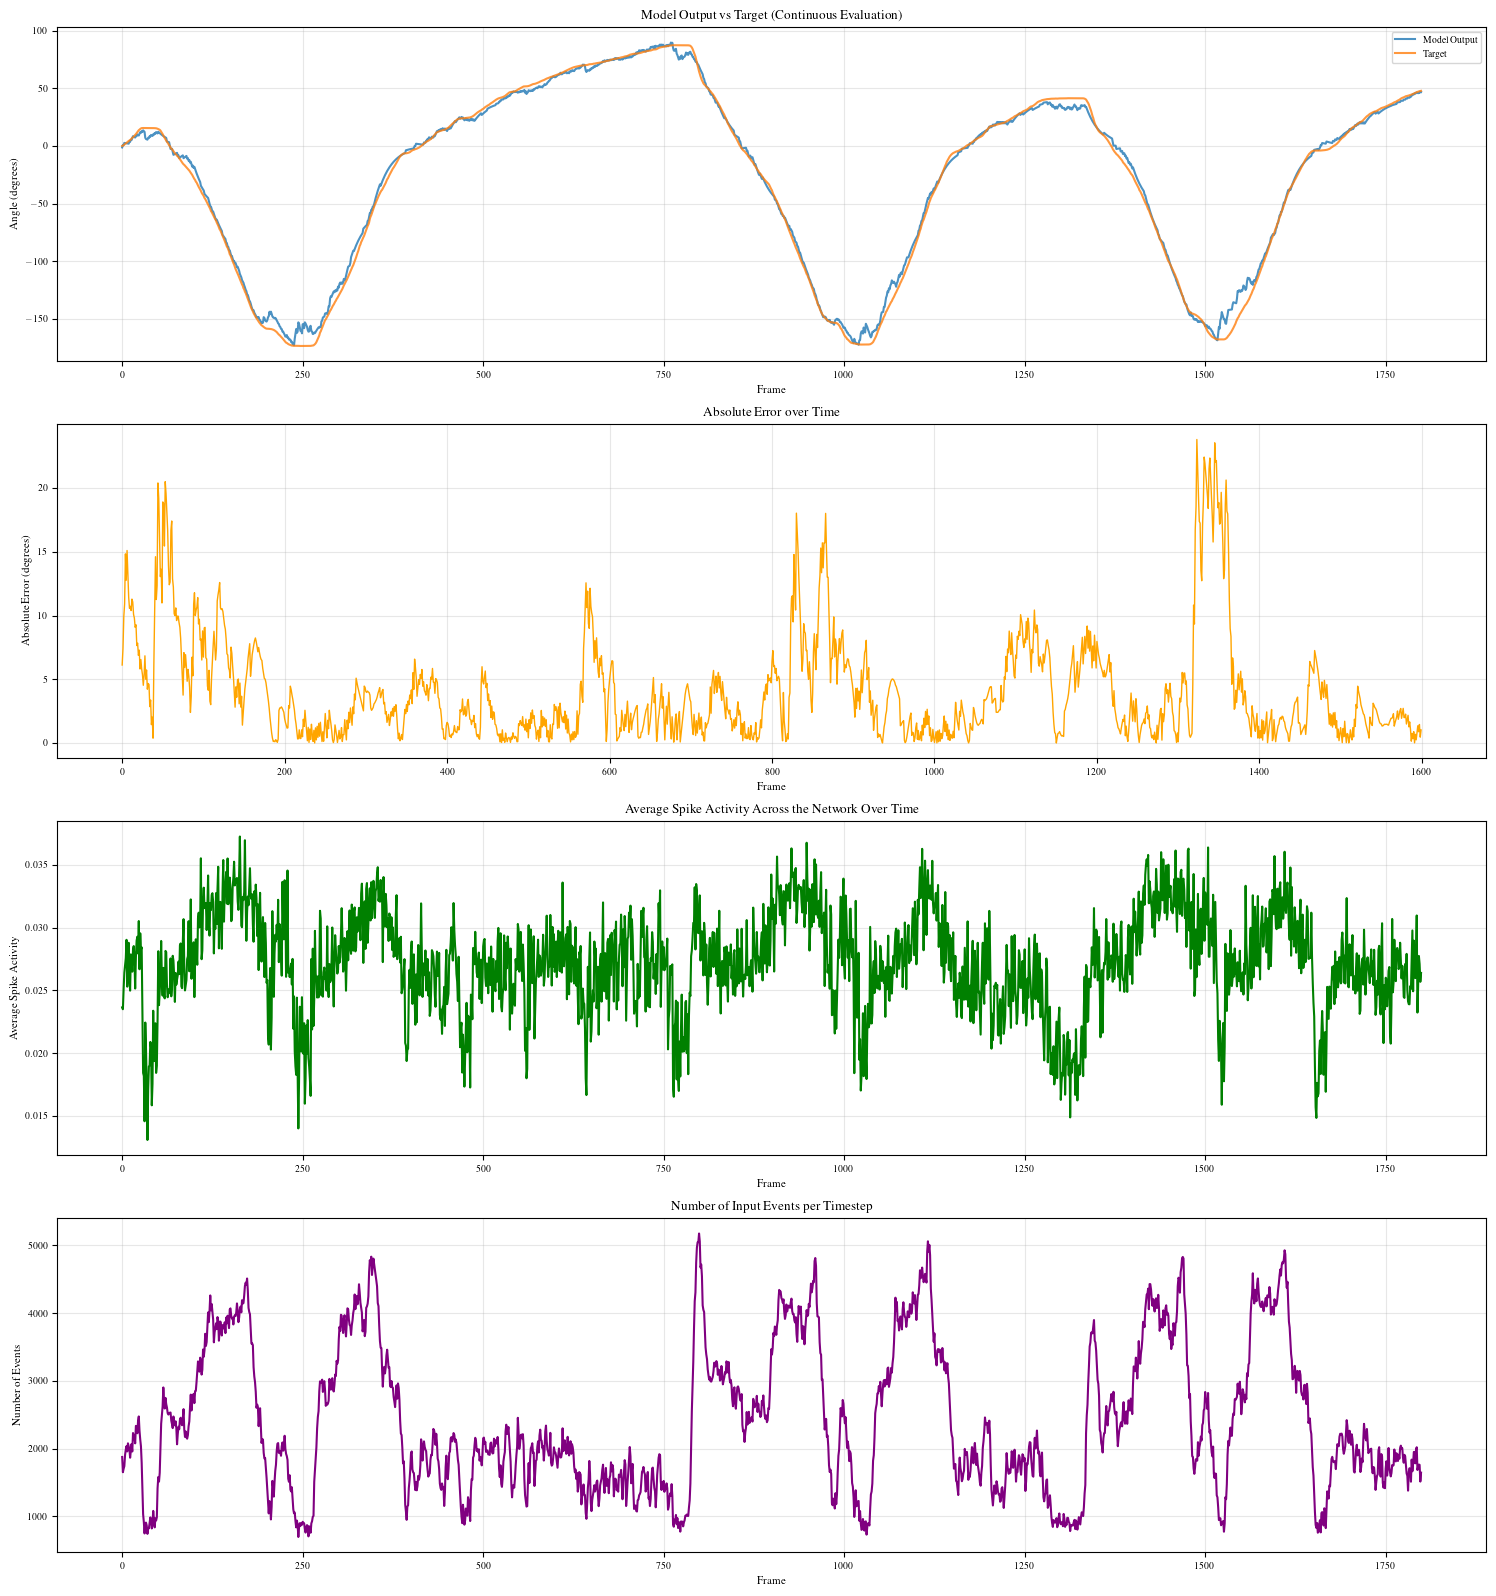


Error statistics:
  Mean error: 5.74°
  Std error: 10.15°
  Max error: 163.84°

Error statistics Window:
  Mean error: 4.01°
  Std error: 3.98°
  Max error: 23.81°


In [33]:
# Continuous results visualization
fig, axes = plt.subplots(n_plots, 1, figsize=(15, 16))  # 4 subplots

# Plot a longer window to see continuous behavior
window_start = 200
window_end = min(2000, len(test_mem_continuous))

# Subplot 1: Model output vs target
axes[0].plot(test_mem_continuous[window_start:window_end] * 180, label="Model Output", alpha=0.8, linewidth=1.5)
axes[0].plot(test_target_continuous[window_start:window_end] * 180, label="Target", alpha=0.8, linewidth=1.5)
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Angle (degrees)")
axes[0].set_title("Model Output vs Target (Continuous Evaluation)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Subplot 2: Absolute error
test_error = np.abs(test_mem_continuous[window_start:window_end] - test_target_continuous[window_start:window_end]) * 180
axes[1].plot(test_error[window_start:window_end], color='orange', linewidth=1)
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Absolute Error (degrees)")
axes[1].set_title("Absolute Error over Time")
axes[1].grid(True, alpha=0.3)

if monitor_mode in ["spikes", "both"]:
    # Subplot 3: Average spike activity
    axes[2].plot(spike_activity_total[window_start:window_end], color='green', linewidth=1.5)
    axes[2].set_xlabel("Frame")
    axes[2].set_ylabel("Average Spike Activity")
    axes[2].set_title("Average Spike Activity Across the Network Over Time")
    axes[2].grid(True, alpha=0.3)

    # Subplot 4: Number of input events
    axes[3].plot(num_events_per_timestep[window_start:window_end], color='purple', linewidth=1.5)
    axes[3].set_xlabel("Frame")
    axes[3].set_ylabel("Number of Events")
    axes[3].set_title("Number of Input Events per Timestep")
    axes[3].grid(True, alpha=0.3)

    print("\nSpike activity statistics (average over time):")
    for k in all_layers:
        mean_spike = np.mean(spike_activity_over_time[k])
        print(f"  {k:20s}: {mean_spike:.4f}")

    print(f"\nAverage spike activity across the entire network: {np.mean(spike_activity_total):.4f}")

plt.tight_layout()
plt.show()

print(f"\nError statistics:")
print(f"  Mean error: {np.mean(np.abs(test_mem_continuous - test_target_continuous) * 180):.2f}°")
print(f"  Std error: {np.std(np.abs(test_mem_continuous - test_target_continuous) * 180):.2f}°")
print(f"  Max error: {np.max(np.abs(test_mem_continuous - test_target_continuous) * 180):.2f}°")


print(f"\nError statistics Window:")
print(f"  Mean error: {np.mean(np.abs(test_mem_continuous[window_start:window_end] - test_target_continuous[window_start:window_end]) * 180):.2f}°")
print(f"  Std error: {np.std(np.abs(test_mem_continuous[window_start:window_end] - test_target_continuous[window_start:window_end]) * 180):.2f}°")
print(f"  Max error: {np.max(np.abs(test_mem_continuous[window_start:window_end] - test_target_continuous[window_start:window_end]) * 180):.2f}°")

### Normalization Statistics Analysis

Analyzes how normalization layers transform activations over time.

In [ ]:
def plot_norm_activity_over_time(norm_activity_over_time, layer_name):
    """Visualize how normalization statistics evolve over time."""
    activity = norm_activity_over_time[layer_name]
    timesteps = np.arange(len(activity['input_mean']))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Activity Over Time: {layer_name}', fontsize=16)

    # Plot 1: Mean evolution
    ax = axes[0, 0]
    ax.plot(timesteps, activity['input_mean'], '-', label='Input Mean', alpha=0.7, linewidth=2)
    ax.plot(timesteps, activity['output_mean'], '-', label='Output Mean', alpha=0.7, linewidth=2)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Mean')
    ax.set_title('Mean Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Std evolution
    ax = axes[0, 1]
    ax.plot(timesteps, activity['input_std'], '-', label='Input Std', alpha=0.7, linewidth=2)
    ax.plot(timesteps, activity['output_std'], '-', label='Output Std', alpha=0.7, linewidth=2)
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Std')
    ax.set_title('Std Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 3: Range evolution
    ax = axes[1, 0]
    ax.plot(timesteps, activity['input_range'], '-', label='Input Range', alpha=0.7, linewidth=2)
    ax.plot(timesteps, activity['output_range'], '-', label='Output Range', alpha=0.7, linewidth=2)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Range (max - min)')
    ax.set_title('Value Range Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 4: Actual scaling factor (output / input)
    ax = axes[1, 1]

    # Calculate scaling factors
    std_scaling = np.array(activity['output_std']) / (np.array(activity['input_std']) + 1e-8)
    range_scaling = np.array(activity['output_range']) / (np.array(activity['input_range']) + 1e-8)

    ax.plot(timesteps, std_scaling, '-', alpha=0.7, linewidth=2,
            label='Std Scaling (out/in)', color='purple')
    ax.plot(timesteps, range_scaling, '-', alpha=0.7, linewidth=2,
            label='Range Scaling (out/in)', color='orange')
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='No scaling (1x)')

    # Add average line
    avg_std_scaling = np.mean(std_scaling)
    ax.axhline(y=avg_std_scaling, color='purple', linestyle=':', alpha=0.7, linewidth=2,
               label=f'Avg Std Scaling: {avg_std_scaling:.1f}x')

    ax.set_xlabel('Timestep')
    ax.set_ylabel('Scaling Factor (Output / Input)')
    ax.set_title('Amplification Factor Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)  # Ensure starts at 0

    plt.tight_layout()
    return fig

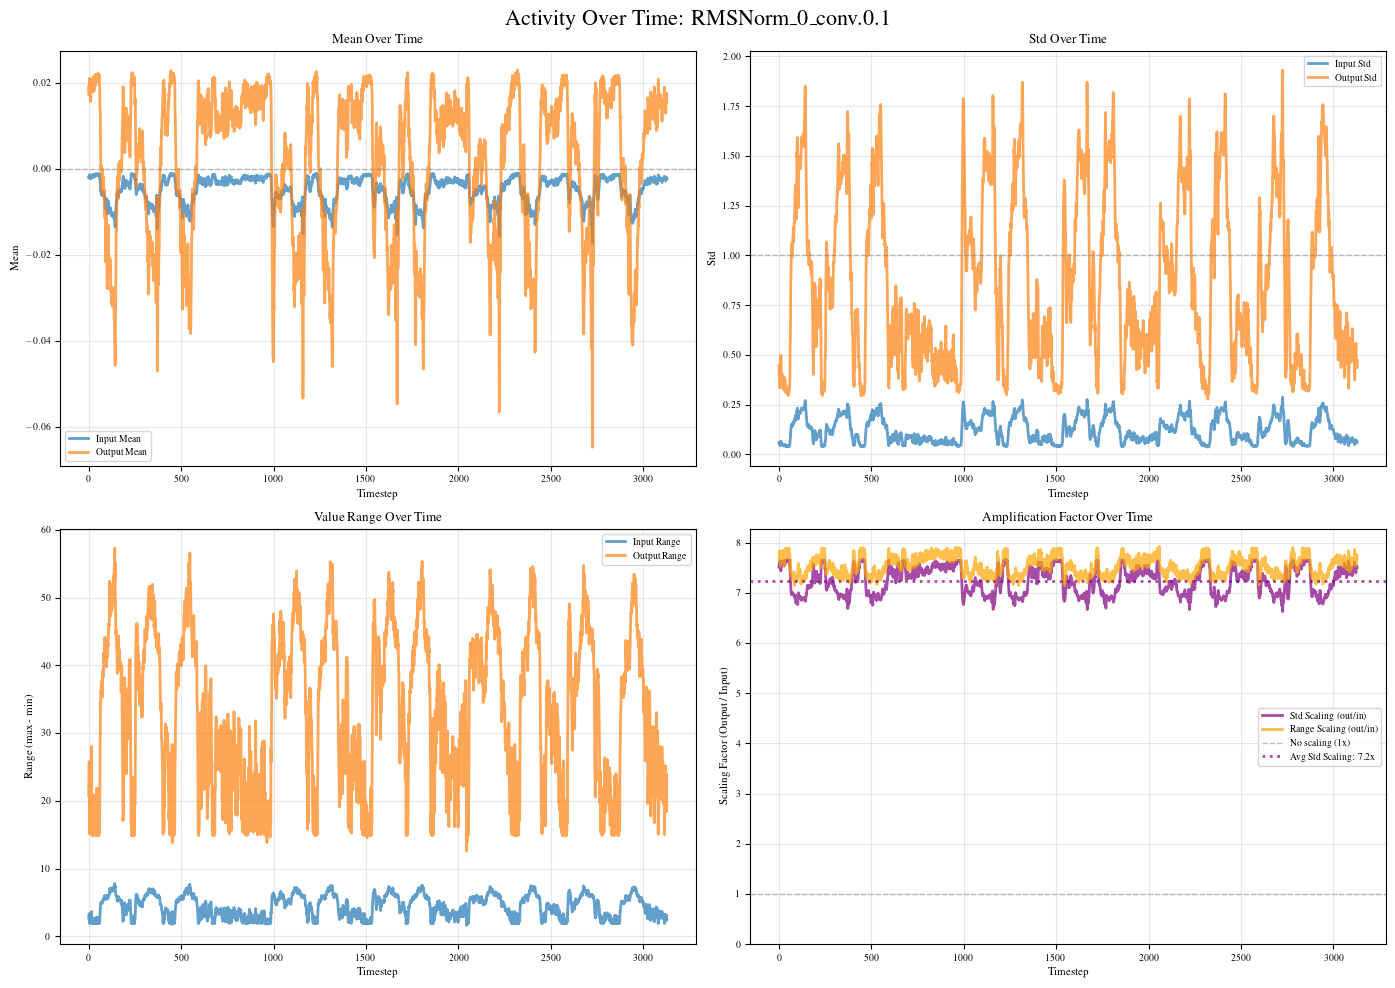

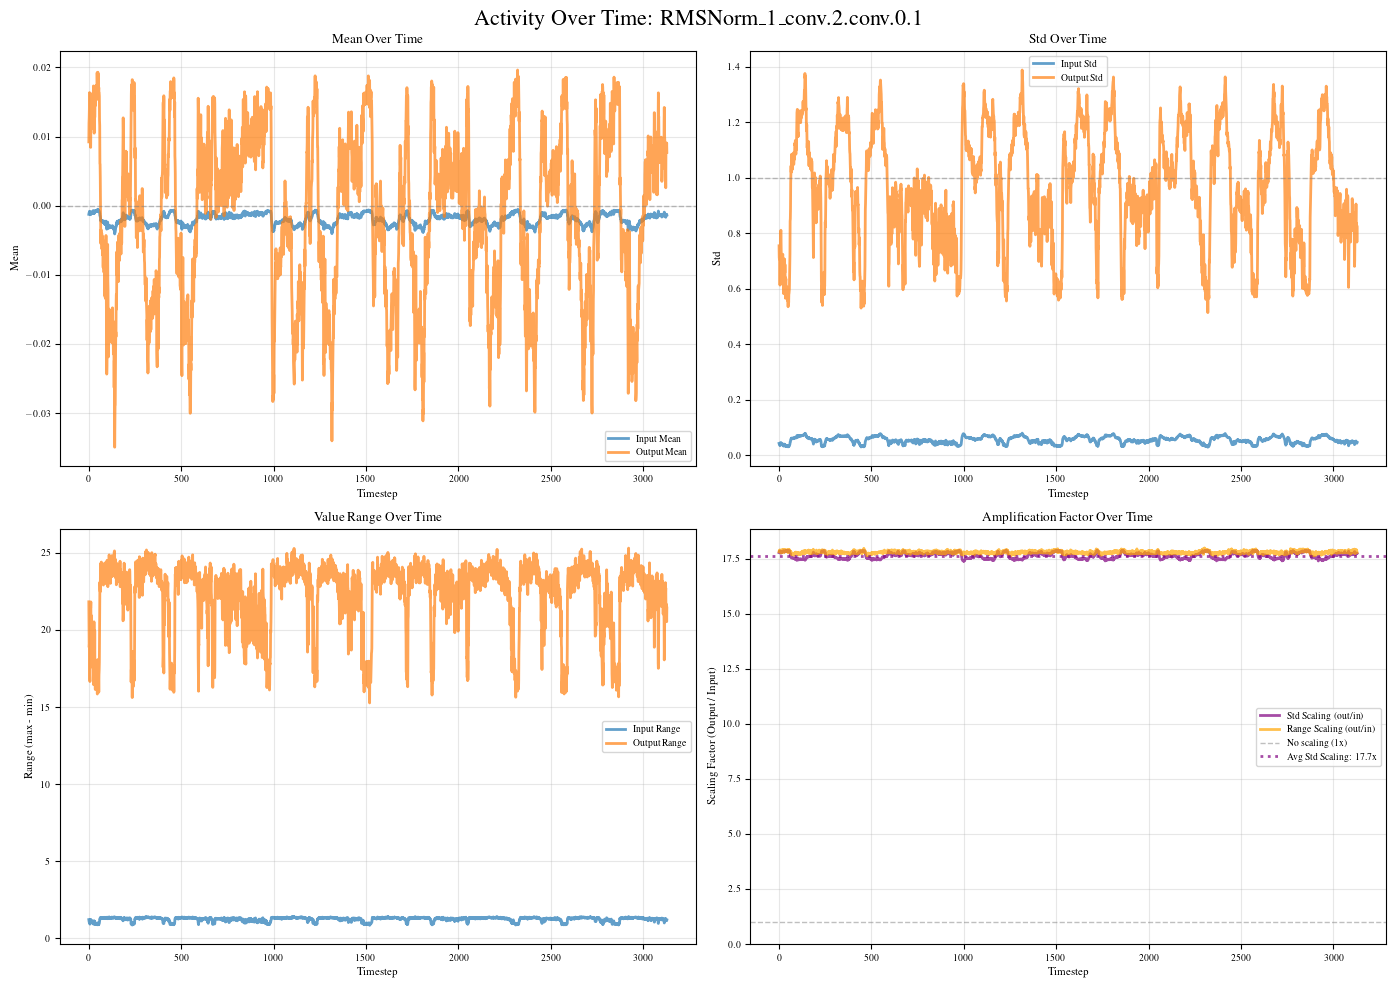

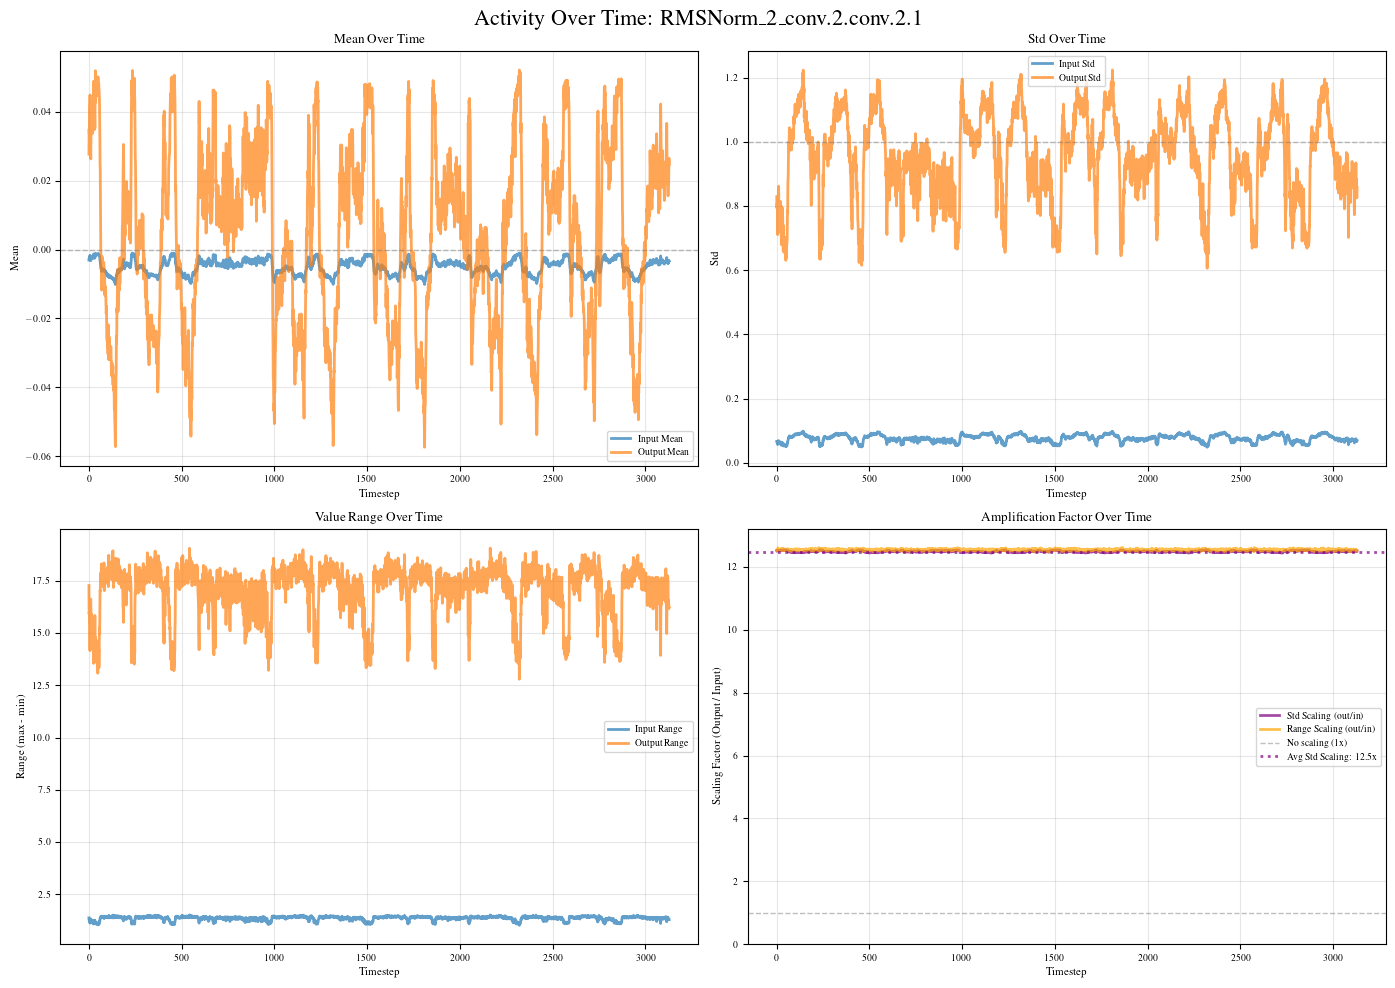

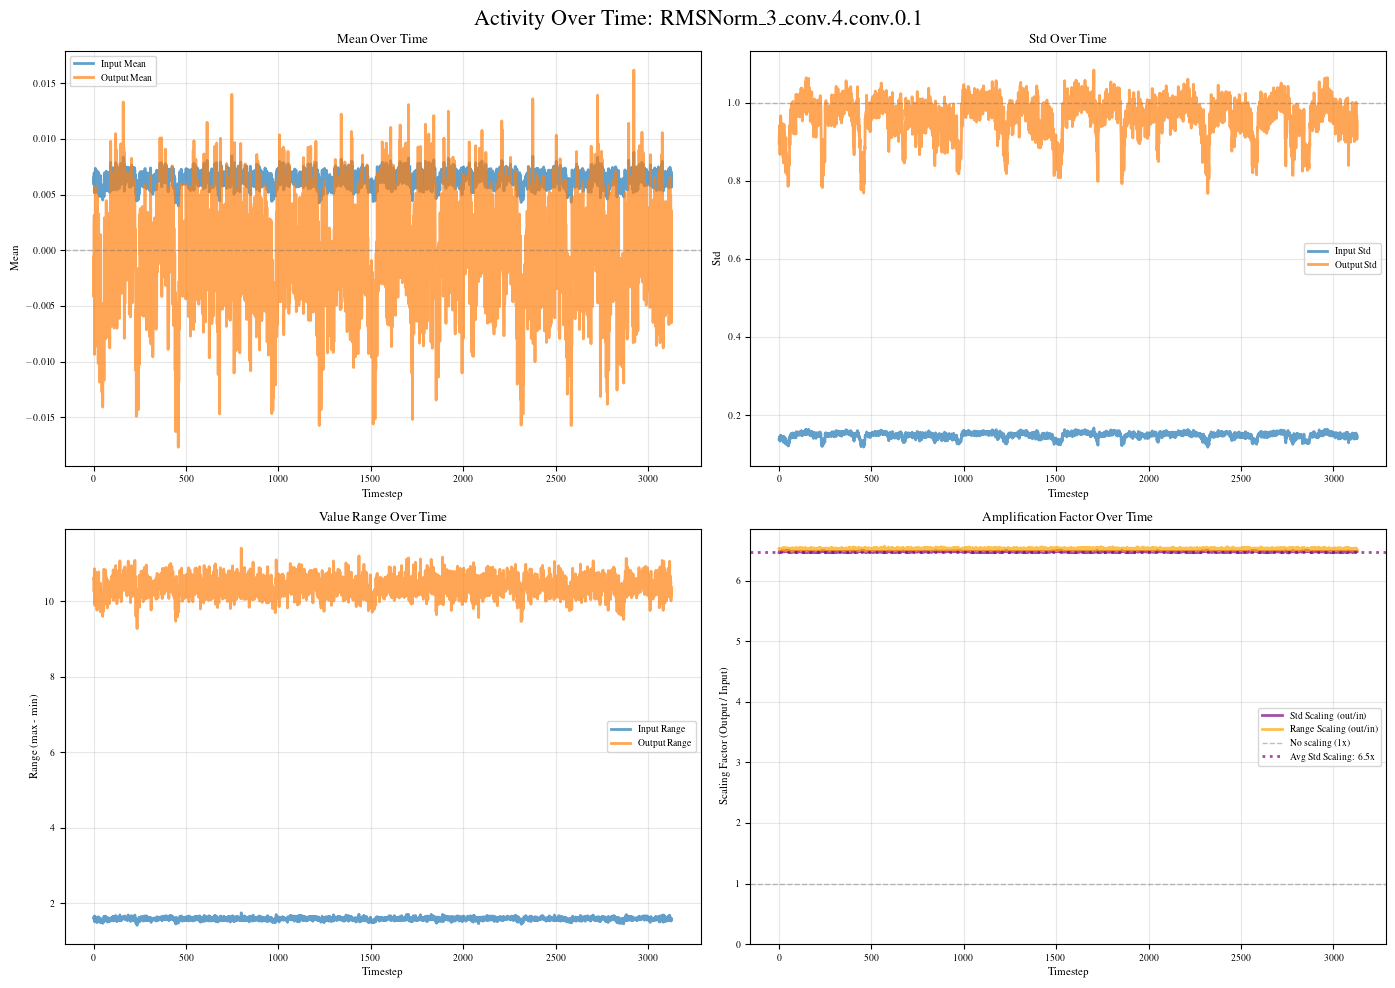

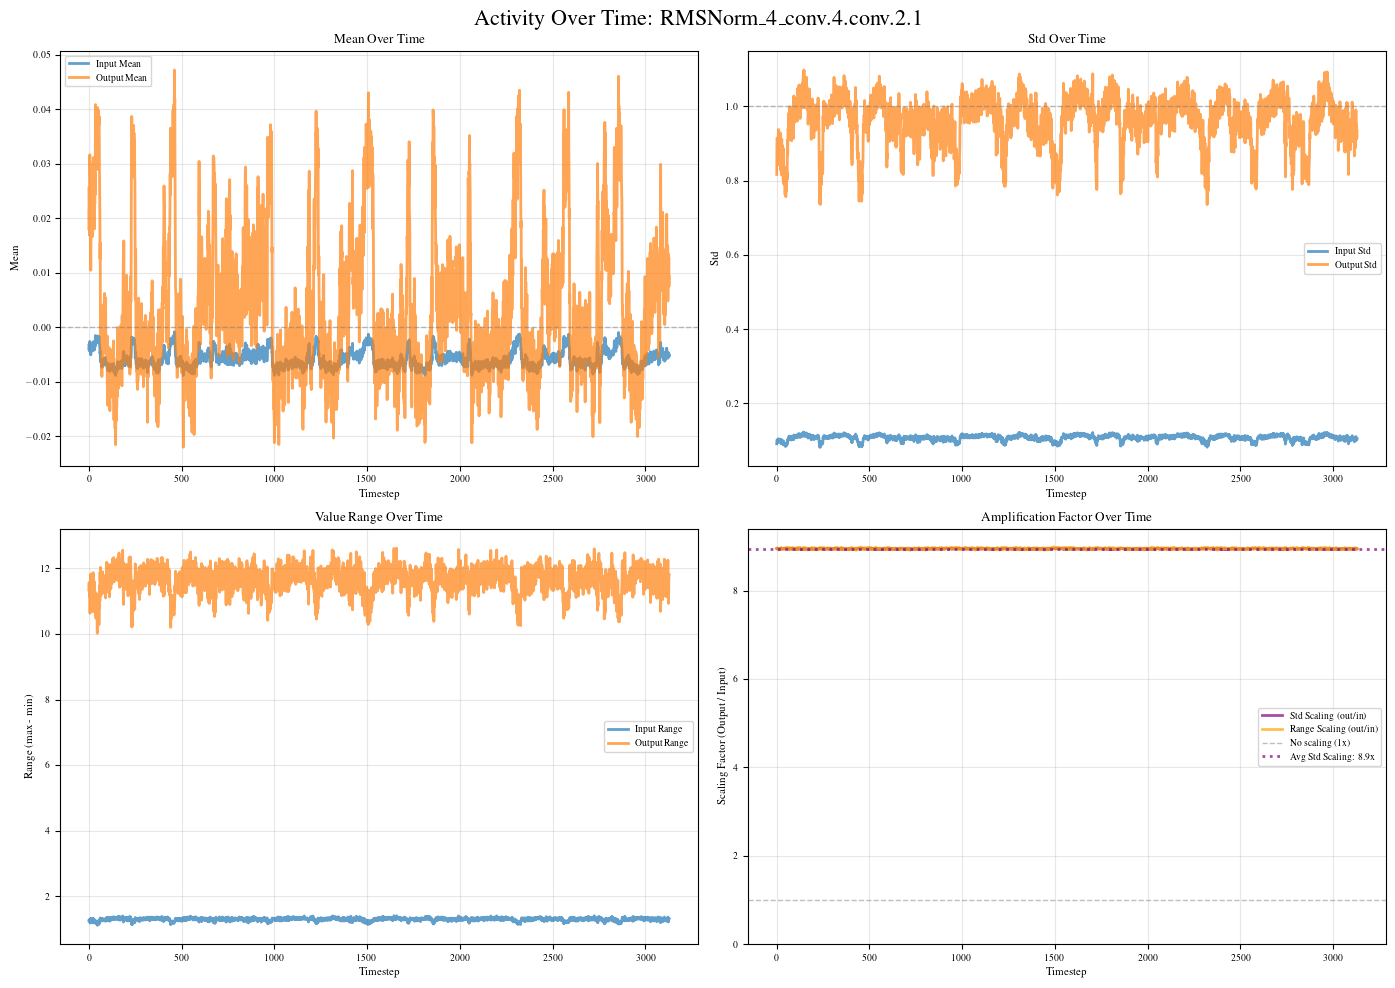

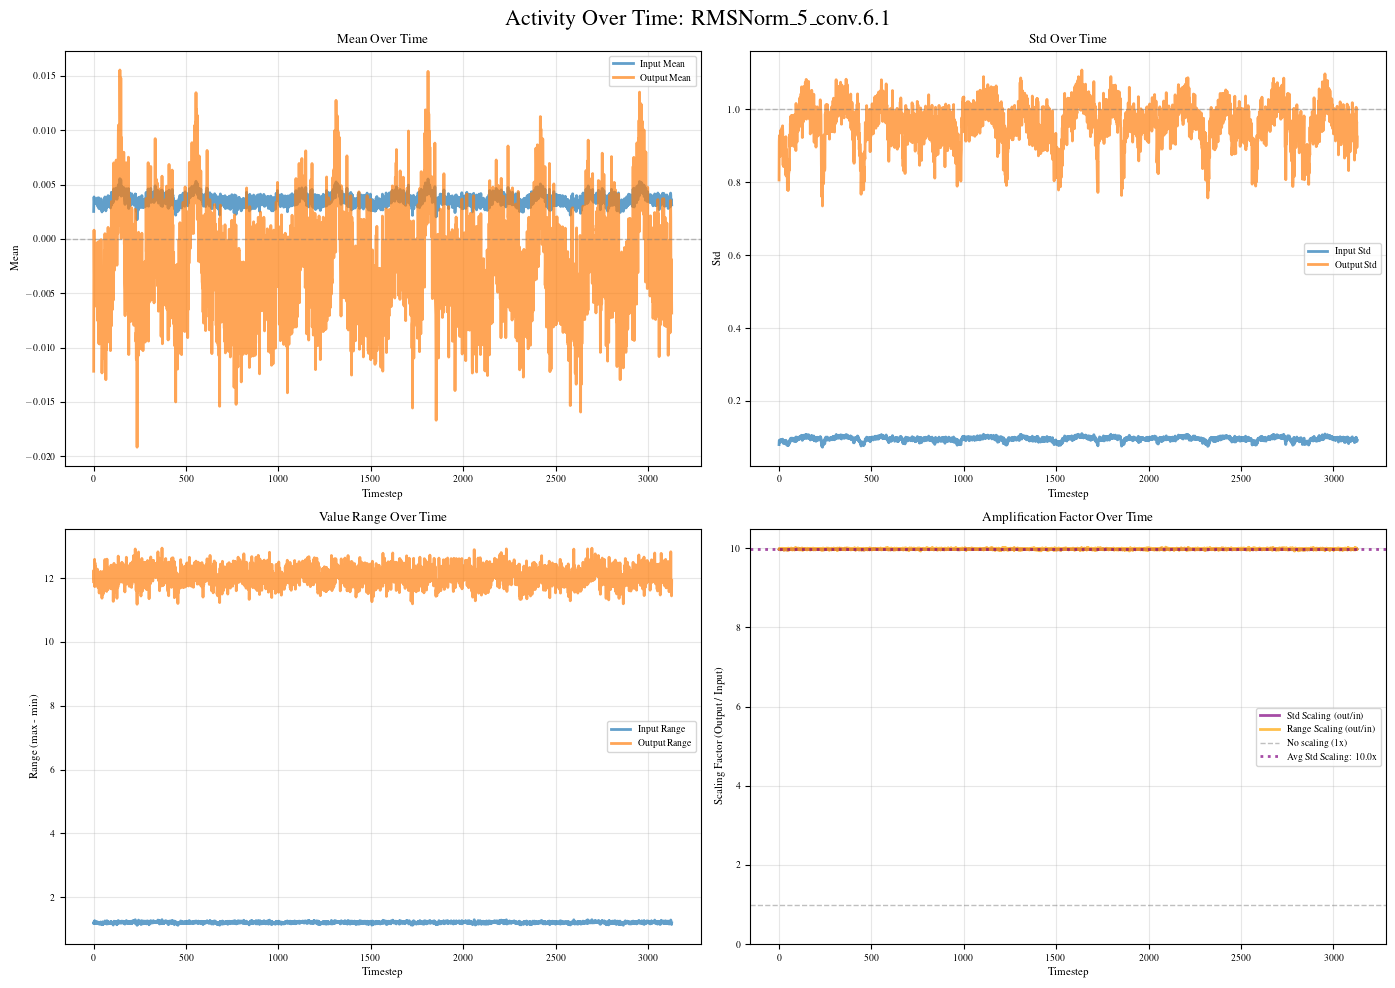

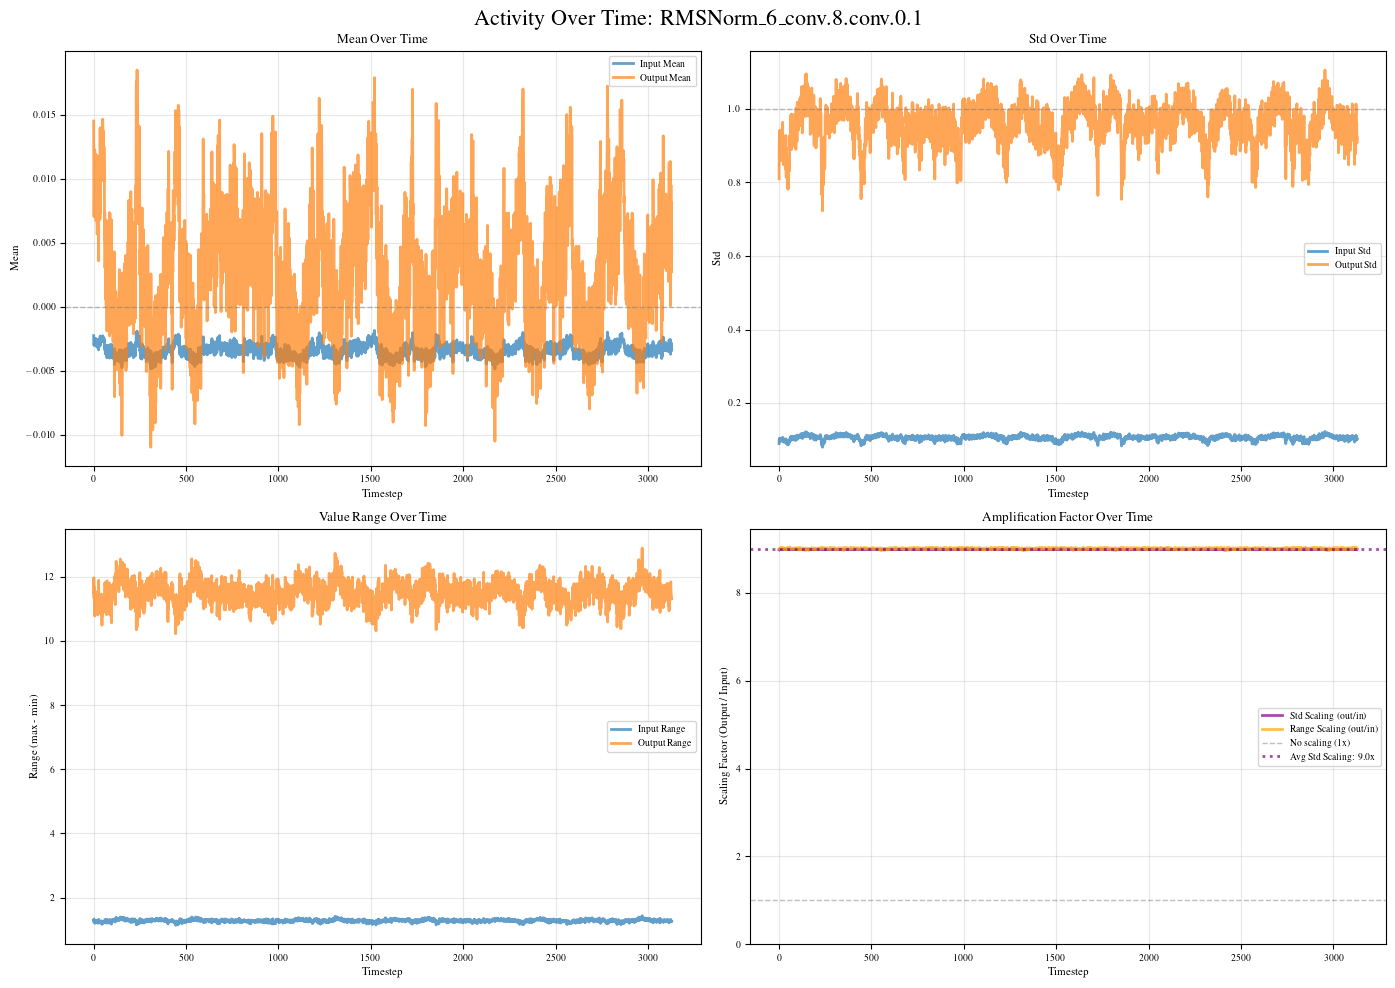

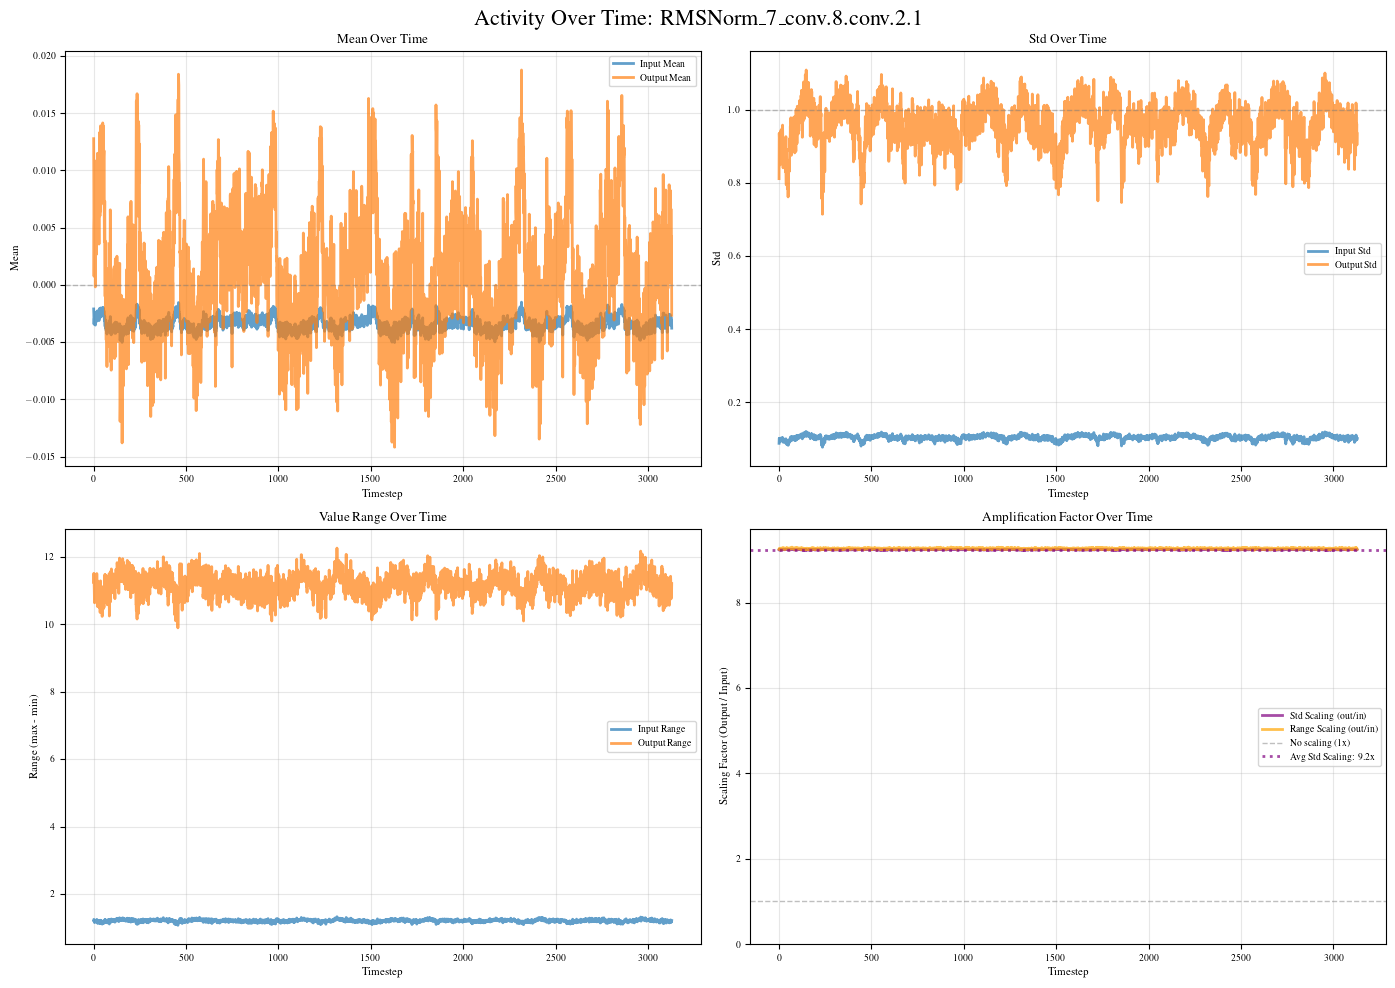

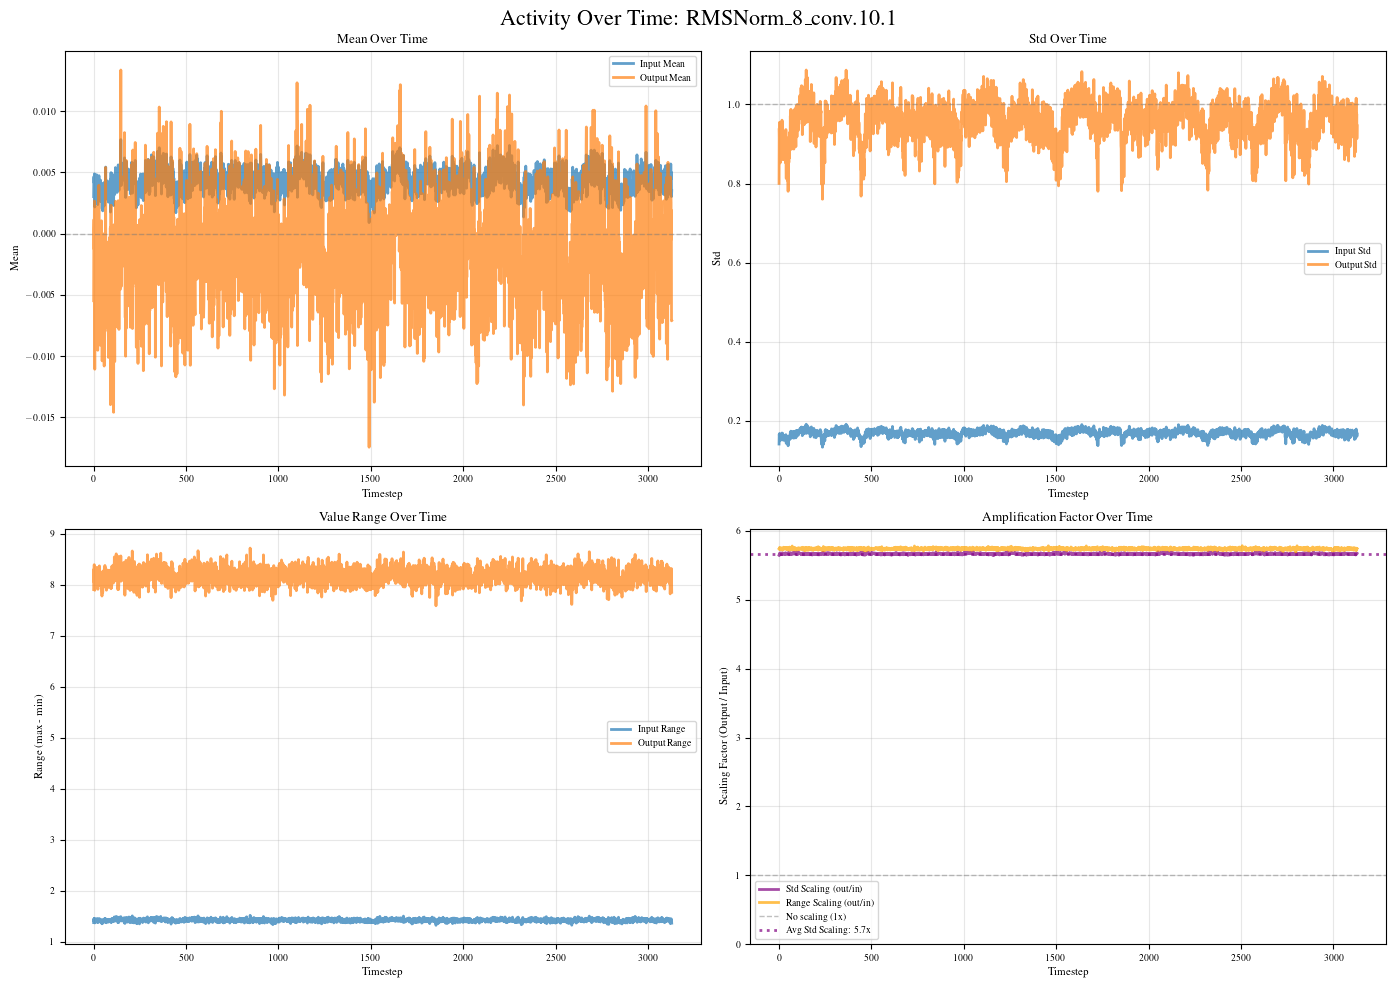

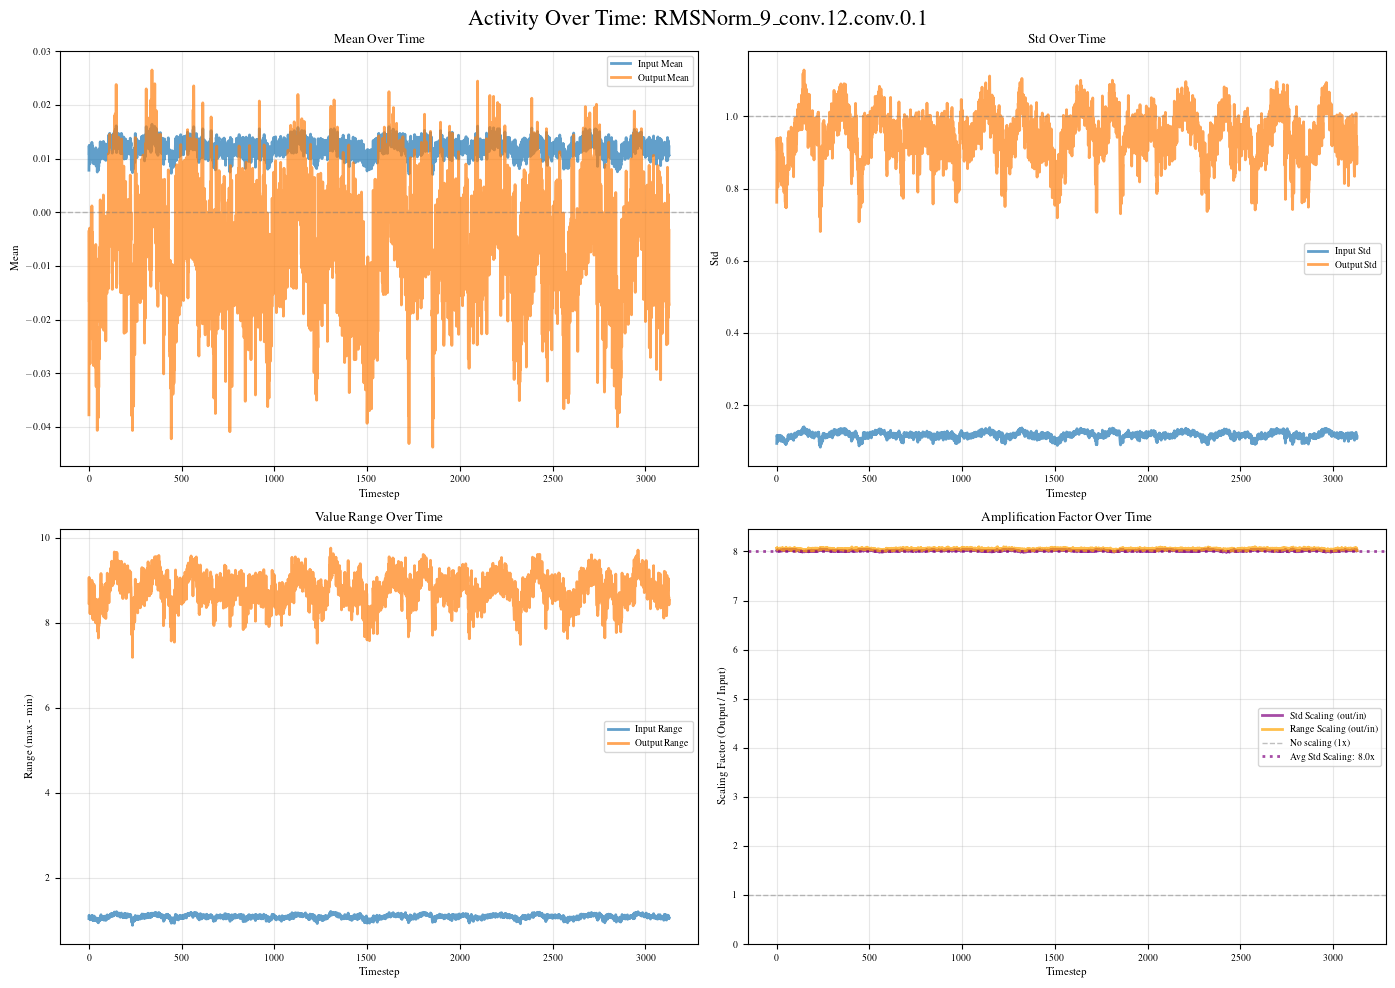

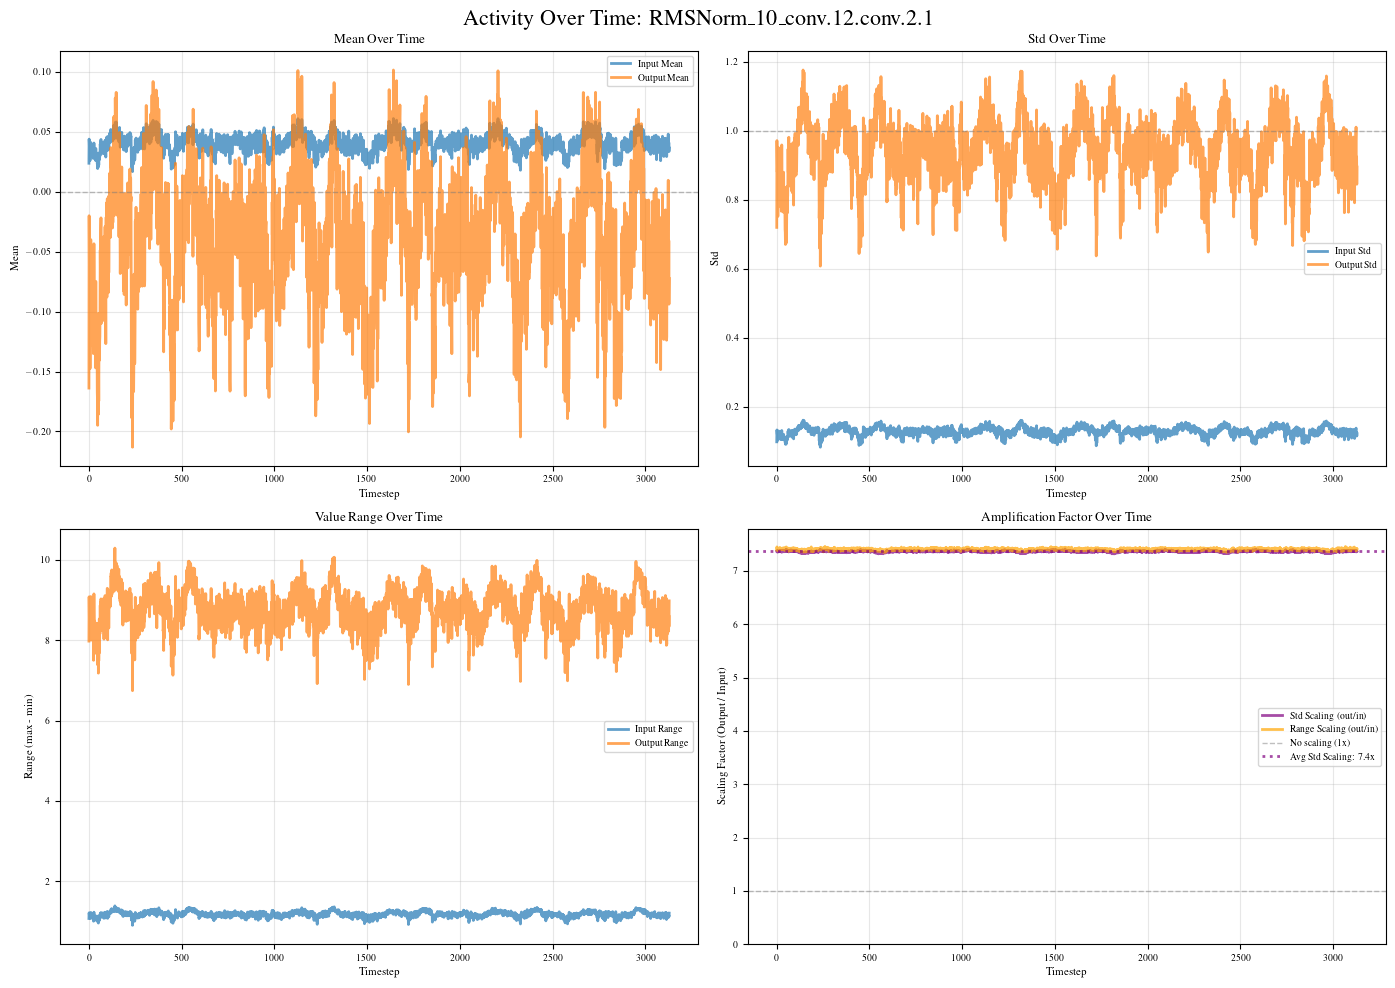

In [35]:
if monitor_mode in ["norm", "both"]:
    # Visualizar para cada capa BatchNorm
    for layer_name in norm_activity_over_time.keys():
        fig = plot_norm_activity_over_time(norm_activity_over_time, layer_name)
        plt.show()
        # O guardar: fig.savefig(f'{layer_name}_temporal_analysis.png')

In [ ]:
def compute_mean_amplification_per_layer(norm_activity_over_time):
    """Compute average amplification factor (std_out / std_in) over time for each layer."""
    layer_names = []
    mean_amplifications = []

    for layer_name, activity in norm_activity_over_time.items():
        input_std = np.array(activity['input_std'])
        output_std = np.array(activity['output_std'])

        std_scaling = output_std / (input_std + 1e-8)
        mean_scaling = std_scaling.mean()

        layer_names.append(layer_name)
        mean_amplifications.append(mean_scaling)

    return layer_names, np.array(mean_amplifications)

def plot_network_amplification(layer_names, mean_amplifications):
    """Bar plot showing average amplification factor per layer."""
    layers = np.arange(len(layer_names))

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.bar(layers, mean_amplifications, alpha=0.8, color='purple')
    ax.axhline(1.0, color='red', linestyle='--', linewidth=2, label='No scaling (1x)')

    avg_network = mean_amplifications.mean()
    ax.axhline(avg_network, color='black', linestyle=':', linewidth=2,
               label=f'Network avg = {avg_network:.1f}x')

    ax.set_xlabel('Layer')
    ax.set_ylabel('Mean Amplification (Output / Input)')
    ax.set_title(f'Mean Amplification Factor per Layer (avg={avg_network:.1f}x)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

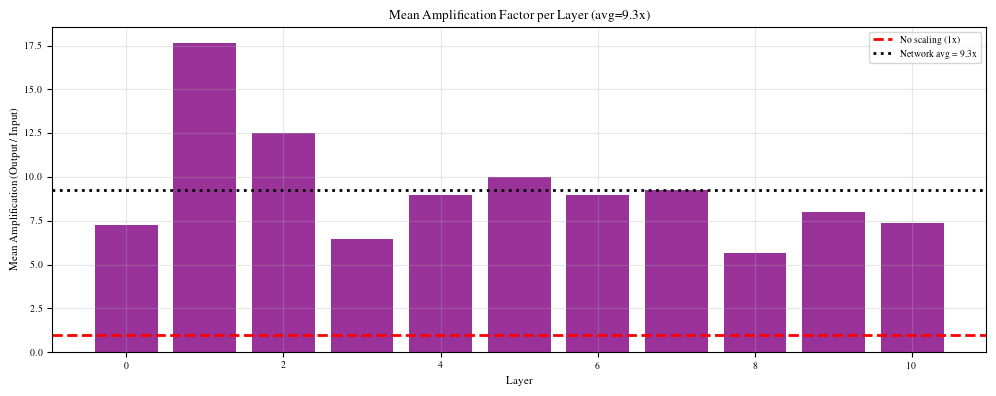

In [38]:
if monitor_mode in ["norm", "both"]:
    layer_names, mean_amplifications = compute_mean_amplification_per_layer(
        norm_activity_over_time
    )

    fig = plot_network_amplification(layer_names, mean_amplifications)
    plt.show()


In [ ]:
if use_wandb:
    wandb.finish()